In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import json
import splitfolders

In [2]:
#splitfolders.ratio('Garbage_Collective_Data', output="data", seed=1337, ratio=(0.8, 0.2)) 

In [3]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
def dumpHistory(name, hist):
    acc, val_acc, loss, val_loss = [],[],[],[]
    if(os.path.isfile('history/' + name + '.json')):
        acc, val_acc, loss, val_loss = loadHistory(name)
    acc += hist.history['accuracy']
    val_acc += hist.history['val_accuracy']

    loss += hist.history['loss']
    val_loss += hist.history['val_loss']

    hist_dict = {
        "acc": acc,
        "val_acc": val_acc,
        "loss": loss,
        "val_loss": val_loss
    }

    with open('history/' + name + '.json', 'w', encoding='utf-8') as f:
        json.dump(hist_dict, f, ensure_ascii=False, indent=4)
    print('DUMPED\n')

In [5]:
def loadHistory(name):
    with open('history/' + name + '.json', "r") as read_file:
        hist_dict = json.load(read_file)

    acc = hist_dict['acc']
    val_acc = hist_dict['val_acc']
    loss = hist_dict['loss']
    val_loss = hist_dict['val_loss']
    return acc, val_acc, loss, val_loss

In [6]:
def distplayHistory(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [7]:
base_learning_rate = 5e-3
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
PATH = os.path.join('data_garbage')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

min_LR = 1e-5
max_LR = 1e-3
step_size = 8
clr_method = "triangular"
clr = CyclicLR(mode = clr_method,base_lr=min_LR, max_lr=max_LR,step_size=step_size*BATCH_SIZE)

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE, 
                                                            label_mode = 'categorical')
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = 'categorical')

Found 12473 files belonging to 12 classes.
Found 3123 files belonging to 12 classes.


In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 40
Number of test batches: 9


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
preprocess_input = tf.keras.applications.xception.preprocess_input

XCEPTION

XCEPTION NO TRANSFER

In [10]:
preprocess_input_XNT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XNT = IMG_SIZE + (3,)
xception_model_XNT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XNT,
                                               include_top=False)
image_batch_XNT, label_batch_XNT = next(iter(train_dataset))
feature_batch_XNT = xception_model_XNT(image_batch_XNT)

global_average_layer_XNT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XNT = global_average_layer_XNT(feature_batch_XNT)

'''fc1_layer_XNT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_XNT = fc1_layer_XNT(feature_batch_average_XNT)'''

prediction_layer_XNT = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_XNT = prediction_layer_XNT(feature_batch_average_XNT)

inputs_XNT = tf.keras.Input(shape=(160, 160, 3))
x_XNT = preprocess_input_XNT(inputs_XNT)
x_XNT = xception_model_XNT(x_XNT)
x_XNT = global_average_layer_XNT(x_XNT)
'''x_XNT = tf.keras.layers.Dropout(0.2)(x_XNT)
x_XNT = fc1_layer_XNT(x_XNT)'''
x_XNT = tf.keras.layers.Dropout(0.2)(x_XNT)
outputs_XNT = prediction_layer_XNT(x_XNT)
model_XNT = tf.keras.Model(inputs_XNT, outputs_XNT)
model_XNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XNT = "training_models/Garbage_XNT.ckpt"
checkpoint_dir_XNT = os.path.dirname(checkpoint_path_XNT)
cp_callback_XNT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [11]:
total_epochs_XNT = 10
history_XNT = model_XNT.fit(train_dataset,
                         epochs=total_epochs_XNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XNT])
initial_epochs_XNT=total_epochs_XNT
dumpHistory('XNTceptionXRAY', history_XNT)

Epoch 1/10
195/195 [==============================] - 1214s 6s/step - loss: 1.7814 - accuracy: 0.4124 - val_loss: 1.4239 - val_accuracy: 0.4967
Epoch 2/10
195/195 [==============================] - 480s 2s/step - loss: 1.2854 - accuracy: 0.6368 - val_loss: 1.0569 - val_accuracy: 0.7283
Epoch 3/10
195/195 [==============================] - 494s 3s/step - loss: 0.9451 - accuracy: 0.7611 - val_loss: 0.7790 - val_accuracy: 0.8088
Epoch 4/10
195/195 [==============================] - 482s 2s/step - loss: 0.6998 - accuracy: 0.8264 - val_loss: 0.5930 - val_accuracy: 0.8512
Epoch 5/10
195/195 [==============================] - 463s 2s/step - loss: 0.5323 - accuracy: 0.8676 - val_loss: 0.4804 - val_accuracy: 0.8799
Epoch 6/10
195/195 [==============================] - 464s 2s/step - loss: 0.4281 - accuracy: 0.8927 - val_loss: 0.3932 - val_accuracy: 0.9007
Epoch 7/10
195/195 [==============================] - 465s 2s/step - loss: 0.3497 - accuracy: 0.9090 - val_loss: 0.3376 - val_accuracy: 0.916

In [12]:
model_XNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XNT = 10
total_epochs_XNT =  initial_epochs_XNT + add_epochs_XNT

history_XNT = model_XNT.fit(train_dataset,
                         epochs=total_epochs_XNT,
                         initial_epoch=initial_epochs_XNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XNT, clr])
initial_epochs_XNT+=add_epochs_XNT
dumpHistory('XNTceptionXRAY', history_XNT)

Epoch 11/20
195/195 [==============================] - 473s 2s/step - loss: 0.1997 - accuracy: 0.9489 - val_loss: 0.2416 - val_accuracy: 0.9305
Epoch 12/20
195/195 [==============================] - 468s 2s/step - loss: 0.2009 - accuracy: 0.9487 - val_loss: 0.2448 - val_accuracy: 0.9289
Epoch 13/20
195/195 [==============================] - 468s 2s/step - loss: 0.1954 - accuracy: 0.9487 - val_loss: 0.2425 - val_accuracy: 0.9289
Epoch 14/20
195/195 [==============================] - 468s 2s/step - loss: 0.1929 - accuracy: 0.9489 - val_loss: 0.2352 - val_accuracy: 0.9329
Epoch 15/20
195/195 [==============================] - 468s 2s/step - loss: 0.1902 - accuracy: 0.9516 - val_loss: 0.2349 - val_accuracy: 0.9317
Epoch 16/20
195/195 [==============================] - 462s 2s/step - loss: 0.1850 - accuracy: 0.9514 - val_loss: 0.2407 - val_accuracy: 0.9301
Epoch 17/20
195/195 [==============================] - 466s 2s/step - loss: 0.1878 - accuracy: 0.9521 - val_loss: 0.2357 - val_accuracy:

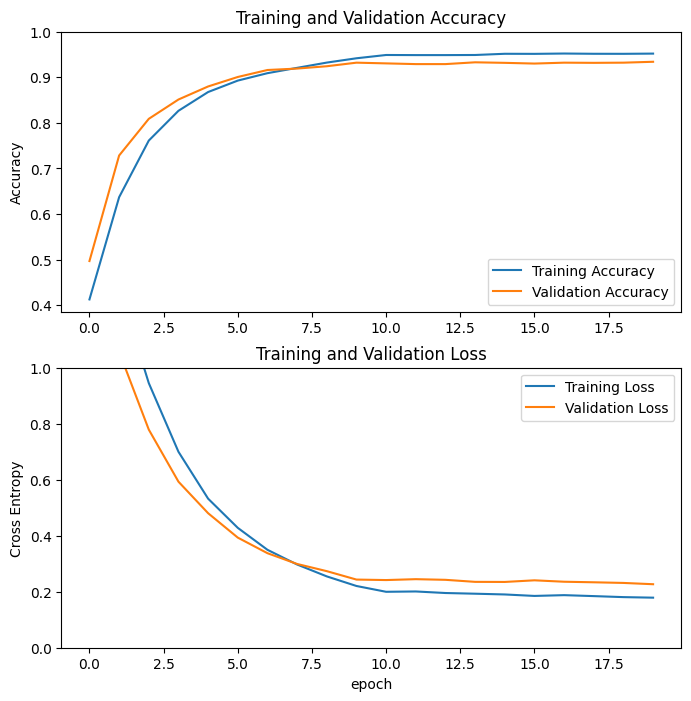

In [13]:
acc_XNT, val_acc_XNT, loss_XNT, val_loss_XNT = loadHistory('XNTceptionXRAY')
distplayHistory(acc_XNT, val_acc_XNT, loss_XNT, val_loss_XNT)

In [14]:
loss0, accuracy0 = model_XNT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss0))
print("Test accuracy: {:.4f}".format(accuracy0))

9/9 [==============================] - 6s 647ms/step - loss: 0.2103 - accuracy: 0.9392
Test loss: 0.2103
Test accuracy: 0.9392


XCEPTION FAST TRANSFER

In [15]:
preprocess_input_XFT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XFT = IMG_SIZE + (3,)
xception_model_XFT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XFT,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XFT.trainable = False
image_batch_XFT, label_batch_XFT = next(iter(train_dataset))
feature_batch_XFT = xception_model_XFT(image_batch_XFT)
global_average_layer_XFT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XFT = global_average_layer_XFT(feature_batch_XFT)

'''fc1_layer_XFT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_XFT = fc1_layer_XFT(feature_batch_average_XFT)'''

prediction_layer_XFT = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_XFT = prediction_layer_XFT(feature_batch_average_XFT)

inputs_XFT = tf.keras.Input(shape=(160, 160, 3))
x_XFT = preprocess_input_XFT(inputs_XFT)
x_XFT = xception_model_XFT(x_XFT)
x_XFT = global_average_layer_XFT(x_XFT)
x_XFT = tf.keras.layers.Dropout(0.2)(x_XFT)
outputs_XFT = prediction_layer_XFT(x_XFT)
model_XFT = tf.keras.Model(inputs_XFT, outputs_XFT)
model_XFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XFT = "training_models/Garbage_XFT.ckpt"
checkpoint_dir_XFT = os.path.dirname(checkpoint_path_XFT)
cp_callback_XFT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XFT,
                                                 save_weights_only=True,
                                                 verbose=0)

In [16]:
total_epochs_XFT = 5
history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT])
initial_epochs_XFT=total_epochs_XFT
dumpHistory('XFTceptionGarbage', history_XFT)

Epoch 1/5
195/195 [==============================] - 157s 788ms/step - loss: 1.2898 - accuracy: 0.6296 - val_loss: 0.8471 - val_accuracy: 0.7841
Epoch 2/5
195/195 [==============================] - 153s 783ms/step - loss: 0.7371 - accuracy: 0.8053 - val_loss: 0.6468 - val_accuracy: 0.8300
Epoch 3/5
195/195 [==============================] - 153s 783ms/step - loss: 0.5893 - accuracy: 0.8385 - val_loss: 0.5479 - val_accuracy: 0.8508
Epoch 4/5
195/195 [==============================] - 153s 783ms/step - loss: 0.5144 - accuracy: 0.8571 - val_loss: 0.4957 - val_accuracy: 0.8642
Epoch 5/5
195/195 [==============================] - 153s 783ms/step - loss: 0.4709 - accuracy: 0.8673 - val_loss: 0.4659 - val_accuracy: 0.8681
DUMPED



In [17]:
xception_model_XFT.trainable = True
fine_tune_at_XFT = 120
for layer_XFT in xception_model_XFT.layers[:fine_tune_at_XFT]:
  layer_XFT.trainable = False
model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XFT = 1
total_epochs_XFT =  initial_epochs_XFT + fine_tune_epochs_XFT

history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=initial_epochs_XFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT])
dumpHistory('XFTceptionGarbage', history_XFT)
initial_epochs_XFT += fine_tune_epochs_XFT
for i in range (4):
  xception_model_XFT.trainable = True
  fine_tune_at_XFT -= 30
  for layer_XFT in xception_model_XFT.layers[:fine_tune_at_XFT]:
    layer_XFT.trainable = False
  model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XFT = 1
  total_epochs_XFT =  initial_epochs_XFT + fine_tune_epochs_XFT


  history_XFT = model_XFT.fit(train_dataset,
                          epochs=total_epochs_XFT,
                          initial_epoch=initial_epochs_XFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_XFT])
  dumpHistory('XFTceptionGarbage', history_XFT)
  initial_epochs_XFT+=fine_tune_epochs_XFT


Epoch 6/6
195/195 [==============================] - 179s 899ms/step - loss: 1.3239 - accuracy: 0.8138 - val_loss: 0.7379 - val_accuracy: 0.8406
DUMPED

Epoch 7/7
195/195 [==============================] - 231s 1s/step - loss: 1.3426 - accuracy: 0.7817 - val_loss: 1.0828 - val_accuracy: 0.8143
DUMPED

Epoch 8/8
195/195 [==============================] - 280s 1s/step - loss: 1.1802 - accuracy: 0.7852 - val_loss: 1.0677 - val_accuracy: 0.8005
DUMPED

Epoch 9/9
195/195 [==============================] - 338s 2s/step - loss: 1.1080 - accuracy: 0.7753 - val_loss: 1.0114 - val_accuracy: 0.7911
DUMPED

Epoch 10/10
195/195 [==============================] - 463s 2s/step - loss: 0.9916 - accuracy: 0.7876 - val_loss: 0.9338 - val_accuracy: 0.8005
DUMPED



In [18]:
model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XFT = 10
total_epochs_XFT =  initial_epochs_XFT + add_epochs_XFT

history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=initial_epochs_XFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT, clr])
initial_epochs_XFT+=add_epochs_XFT
dumpHistory('XFTceptionGarbage', history_XFT)

Epoch 11/20
195/195 [==============================] - 475s 2s/step - loss: 0.9295 - accuracy: 0.8057 - val_loss: 0.9220 - val_accuracy: 0.8057
Epoch 12/20
195/195 [==============================] - 469s 2s/step - loss: 0.9050 - accuracy: 0.8060 - val_loss: 0.8732 - val_accuracy: 0.8135
Epoch 13/20
195/195 [==============================] - 469s 2s/step - loss: 0.8371 - accuracy: 0.8163 - val_loss: 0.7888 - val_accuracy: 0.8276
Epoch 14/20
195/195 [==============================] - 470s 2s/step - loss: 0.7546 - accuracy: 0.8343 - val_loss: 0.7209 - val_accuracy: 0.8430
Epoch 15/20
195/195 [==============================] - 469s 2s/step - loss: 0.7059 - accuracy: 0.8427 - val_loss: 0.6922 - val_accuracy: 0.8492
Epoch 16/20
195/195 [==============================] - 469s 2s/step - loss: 0.6826 - accuracy: 0.8514 - val_loss: 0.6812 - val_accuracy: 0.8520
Epoch 17/20
195/195 [==============================] - 469s 2s/step - loss: 0.6751 - accuracy: 0.8479 - val_loss: 0.6692 - val_accuracy:

In [19]:
loss1, accuracy1 = model_XFT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss1))
print("Test accuracy: {:.4f}".format(accuracy1))

9/9 [==============================] - 6s 651ms/step - loss: 0.5227 - accuracy: 0.8889
Test loss: 0.5227
Test accuracy: 0.8889


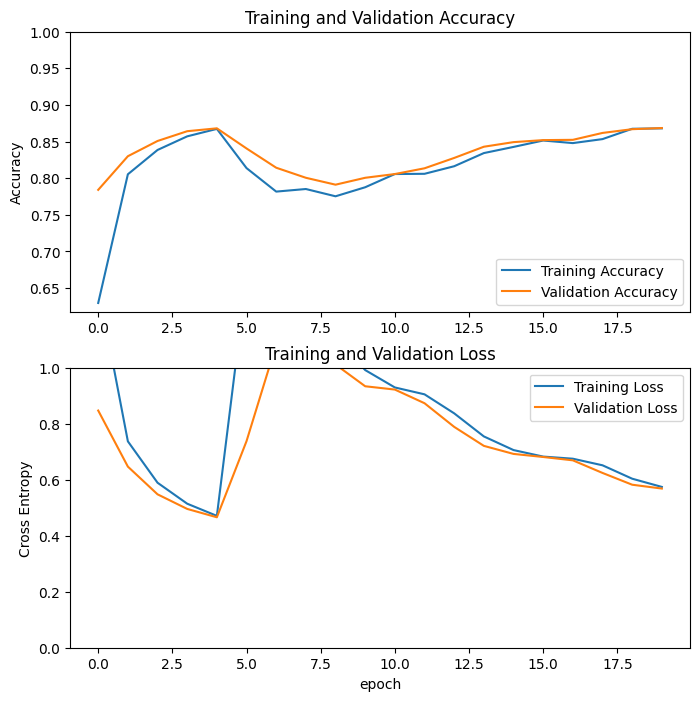

In [20]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('XFTceptionGarbage')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

XCEPTION SLOW TRANSFER

In [11]:
preprocess_input_XST = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XST = IMG_SIZE + (3,)
xception_model_XST = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XST,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XST.trainable = False
image_batch_XST, label_batch_XST = next(iter(train_dataset))
feature_batch_XST = xception_model_XST(image_batch_XST)
global_average_layer_XST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XST = global_average_layer_XST(feature_batch_XST)

'''fc1_layer_XST = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_XST = fc1_layer_XST(feature_batch_average_XST)'''

prediction_layer_XST = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_XST = prediction_layer_XST(feature_batch_average_XST)

inputs_XST = tf.keras.Input(shape=(160, 160, 3))
x_XST = preprocess_input_XST(inputs_XST)
x_XST = xception_model_XST(x_XST)
x_XST = global_average_layer_XST(x_XST)
'''x_XST = tf.keras.layers.Dropout(0.2)(x_XST)
x_XST = fc1_layer_XST(x_XST)'''
x_XST = tf.keras.layers.Dropout(0.2)(x_XST)
outputs_XST = prediction_layer_XST(x_XST)
model_XST = tf.keras.Model(inputs_XST, outputs_XST)
model_XST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XST = "training_models/Garbage_XST.ckpt"
checkpoint_dir_XST = os.path.dirname(checkpoint_path_XST)
cp_callback_XST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XST,
                                                 save_weights_only=True,
                                                 verbose=0)

In [22]:
total_epochs_XST = 10
history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
initial_epochs_XST=total_epochs_XST
dumpHistory('XSTceptionGarbage', history_XST)

Epoch 1/10
195/195 [==============================] - 159s 799ms/step - loss: 1.2996 - accuracy: 0.6201 - val_loss: 0.8395 - val_accuracy: 0.7837
Epoch 2/10
195/195 [==============================] - 155s 794ms/step - loss: 0.7312 - accuracy: 0.8047 - val_loss: 0.6231 - val_accuracy: 0.8351
Epoch 3/10
195/195 [==============================] - 155s 794ms/step - loss: 0.5843 - accuracy: 0.8401 - val_loss: 0.5308 - val_accuracy: 0.8555
Epoch 4/10
195/195 [==============================] - 155s 793ms/step - loss: 0.5140 - accuracy: 0.8575 - val_loss: 0.4901 - val_accuracy: 0.8649
Epoch 5/10
195/195 [==============================] - 155s 793ms/step - loss: 0.4710 - accuracy: 0.8696 - val_loss: 0.4458 - val_accuracy: 0.8763
Epoch 6/10
195/195 [==============================] - 155s 793ms/step - loss: 0.4355 - accuracy: 0.8773 - val_loss: 0.4285 - val_accuracy: 0.8748
Epoch 7/10
195/195 [==============================] - 155s 793ms/step - loss: 0.4089 - accuracy: 0.8838 - val_loss: 0.4036 -

In [23]:
xception_model_XST.trainable = True
fine_tune_at_XST = 120
for layer_XST in xception_model_XST.layers[:fine_tune_at_XST]:
  layer_XST.trainable = False
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XST = 2
total_epochs_XST =  initial_epochs_XST + fine_tune_epochs_XST

history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
dumpHistory('XSTceptionGarbage', history_XST)
initial_epochs_XST += fine_tune_epochs_XST
for i in range (4):
  xception_model_XST.trainable = True
  fine_tune_at_XST -= 30
  for layer_XST in xception_model_XST.layers[:fine_tune_at_XST]:
    layer_XST.trainable = False
  model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XST = 2
  total_epochs_XST =  initial_epochs_XST + fine_tune_epochs_XST


  history_XST = model_XST.fit(train_dataset,
                          epochs=total_epochs_XST,
                          initial_epoch=initial_epochs_XST,
                          validation_data=validation_dataset, callbacks=[cp_callback_XST])
  dumpHistory('XSTceptionGarbage', history_XST)
  initial_epochs_XST+=fine_tune_epochs_XST

Epoch 11/12
195/195 [==============================] - 181s 909ms/step - loss: 1.1708 - accuracy: 0.8478 - val_loss: 0.5984 - val_accuracy: 0.8751
Epoch 12/12
195/195 [==============================] - 176s 904ms/step - loss: 1.0396 - accuracy: 0.8602 - val_loss: 0.8395 - val_accuracy: 0.8653
DUMPED

Epoch 13/14
195/195 [==============================] - 235s 1s/step - loss: 1.1368 - accuracy: 0.8199 - val_loss: 1.0331 - val_accuracy: 0.8437
Epoch 14/14
195/195 [==============================] - 230s 1s/step - loss: 1.0181 - accuracy: 0.8316 - val_loss: 0.9467 - val_accuracy: 0.8465
DUMPED

Epoch 15/16
195/195 [==============================] - 282s 1s/step - loss: 0.9254 - accuracy: 0.8314 - val_loss: 0.8581 - val_accuracy: 0.8433
Epoch 16/16
195/195 [==============================] - 277s 1s/step - loss: 0.8256 - accuracy: 0.8417 - val_loss: 0.7716 - val_accuracy: 0.8492
DUMPED

Epoch 17/18
195/195 [==============================] - 339s 2s/step - loss: 0.8358 - accuracy: 0.8296 - va

In [24]:
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XST = 5
initial_epochs_XST = total_epochs_XST
total_epochs_XST =  initial_epochs_XST + add_epochs_XST

history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST, clr])
initial_epochs_XST+=add_epochs_XST
dumpHistory('XSTceptionGarbage', history_XST)

Epoch 21/25
195/195 [==============================] - 471s 2s/step - loss: 0.6393 - accuracy: 0.8603 - val_loss: 0.6273 - val_accuracy: 0.8634
Epoch 22/25
195/195 [==============================] - 469s 2s/step - loss: 0.6255 - accuracy: 0.8634 - val_loss: 0.6188 - val_accuracy: 0.8634
Epoch 23/25
195/195 [==============================] - 469s 2s/step - loss: 0.6067 - accuracy: 0.8619 - val_loss: 0.5826 - val_accuracy: 0.8700
Epoch 24/25
195/195 [==============================] - 469s 2s/step - loss: 0.5643 - accuracy: 0.8729 - val_loss: 0.5399 - val_accuracy: 0.8779
Epoch 25/25
195/195 [==============================] - 465s 2s/step - loss: 0.5262 - accuracy: 0.8786 - val_loss: 0.5070 - val_accuracy: 0.8842
DUMPED



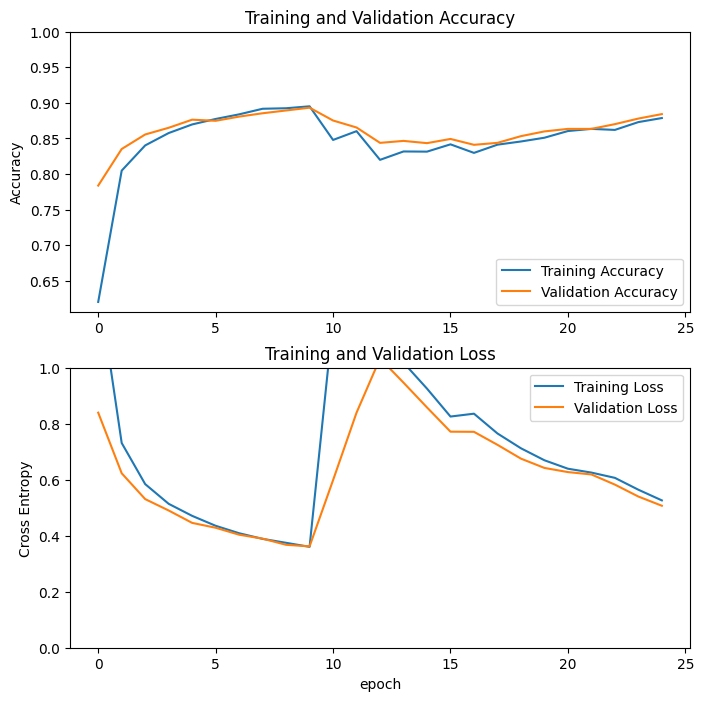

In [25]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('XSTceptionGarbage')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

9/9 [==============================] - 7s 714ms/step - loss: 0.4880 - accuracy: 0.8785


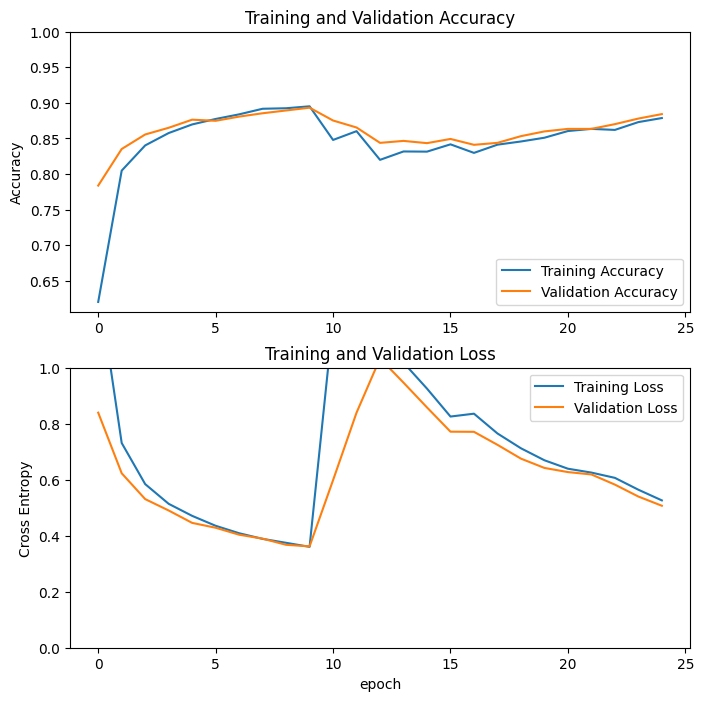

In [13]:
model_XST.load_weights("training_models/Garbage_XST.ckpt")
loss_XST, accuracy_XST = model_XST.evaluate(test_dataset)
acc_XST, val_acc_XST, loss_XST, val_loss_XST = loadHistory('XSTceptionGarbage')
distplayHistory(acc_XST, val_acc_XST, loss_XST, val_loss_XST)

XCEPTION PARTICAL TRSNSFER

In [11]:
preprocess_input_XPT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XPT = IMG_SIZE + (3,)
xception_model_XPT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XPT,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XPT.trainable = False
image_batch_XPT, label_batch_XPT = next(iter(train_dataset))
feature_batch_XPT = xception_model_XPT(image_batch_XPT)
global_average_layer_XPT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XPT = global_average_layer_XPT(feature_batch_XPT)
prediction_layer_XPT = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_XPT = prediction_layer_XPT(feature_batch_average_XPT)
inputs_XPT = tf.keras.Input(shape=(160, 160, 3))
x_XPT = preprocess_input_XPT(inputs_XPT)
x_XPT = xception_model_XPT(x_XPT)
x_XPT = global_average_layer_XPT(x_XPT)
x_XPT = tf.keras.layers.Dropout(0.2)(x_XPT)
outputs_XPT = prediction_layer_XPT(x_XPT)
model_XPT = tf.keras.Model(inputs_XPT, outputs_XPT)
model_XPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XPT = "training_models/Garbage_XPT.ckpt"
checkpoint_dir_XPT = os.path.dirname(checkpoint_path_XPT)
cp_callback_XPT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XPT,
                                                 save_weights_only=True,
                                                 verbose=0)

In [12]:
total_epochs_XPT = 20
history_XPT = model_XPT.fit(train_dataset,
                         epochs=total_epochs_XPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XPT])
initial_epochs_XPT=total_epochs_XPT
dumpHistory('XPTceptionGarbage', history_XPT)

Epoch 1/20
195/195 [==============================] - 176s 868ms/step - loss: 1.2911 - accuracy: 0.6357 - val_loss: 0.8417 - val_accuracy: 0.7998
Epoch 2/20
195/195 [==============================] - 154s 787ms/step - loss: 0.7277 - accuracy: 0.8171 - val_loss: 0.6221 - val_accuracy: 0.8508
Epoch 3/20
195/195 [==============================] - 155s 795ms/step - loss: 0.5810 - accuracy: 0.8503 - val_loss: 0.5383 - val_accuracy: 0.8614
Epoch 4/20
195/195 [==============================] - 161s 827ms/step - loss: 0.5121 - accuracy: 0.8621 - val_loss: 0.4777 - val_accuracy: 0.8783
Epoch 5/20
195/195 [==============================] - 164s 841ms/step - loss: 0.4657 - accuracy: 0.8737 - val_loss: 0.4456 - val_accuracy: 0.8810
Epoch 6/20
195/195 [==============================] - 163s 834ms/step - loss: 0.4351 - accuracy: 0.8796 - val_loss: 0.4216 - val_accuracy: 0.8810
Epoch 7/20
195/195 [==============================] - 163s 833ms/step - loss: 0.4060 - accuracy: 0.8855 - val_loss: 0.4006 -

In [13]:
checkpoint_path_XPT = "training_models/Garbage_XFPT.ckpt"
checkpoint_dir_XPT = os.path.dirname(checkpoint_path_XPT)
cp_callback_XPT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XPT,
                                                 save_weights_only=True,
                                                 verbose=0)
model_XPT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
total_epochs_XPT = 40
history_XPT = model_XPT.fit(train_dataset,
                         epochs=total_epochs_XPT,
                         initial_epoch=initial_epochs_XPT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XPT, clr])
dumpHistory('XPTceptionGarbage', history_XPT)

Epoch 21/40
195/195 [==============================] - 166s 833ms/step - loss: 0.2776 - accuracy: 0.9181 - val_loss: 0.3103 - val_accuracy: 0.9069
Epoch 22/40
195/195 [==============================] - 161s 827ms/step - loss: 0.2824 - accuracy: 0.9169 - val_loss: 0.3125 - val_accuracy: 0.9062
Epoch 23/40
195/195 [==============================] - 162s 829ms/step - loss: 0.2792 - accuracy: 0.9201 - val_loss: 0.3069 - val_accuracy: 0.9085
Epoch 24/40
195/195 [==============================] - 162s 829ms/step - loss: 0.2771 - accuracy: 0.9181 - val_loss: 0.3078 - val_accuracy: 0.9054
Epoch 25/40
195/195 [==============================] - 162s 830ms/step - loss: 0.2800 - accuracy: 0.9189 - val_loss: 0.3097 - val_accuracy: 0.9066
Epoch 26/40
195/195 [==============================] - 162s 828ms/step - loss: 0.2773 - accuracy: 0.9194 - val_loss: 0.3041 - val_accuracy: 0.9077
Epoch 27/40
195/195 [==============================] - 161s 826ms/step - loss: 0.2775 - accuracy: 0.9185 - val_loss: 0

9/9 [==============================] - 7s 680ms/step - loss: 0.3179 - accuracy: 0.9080


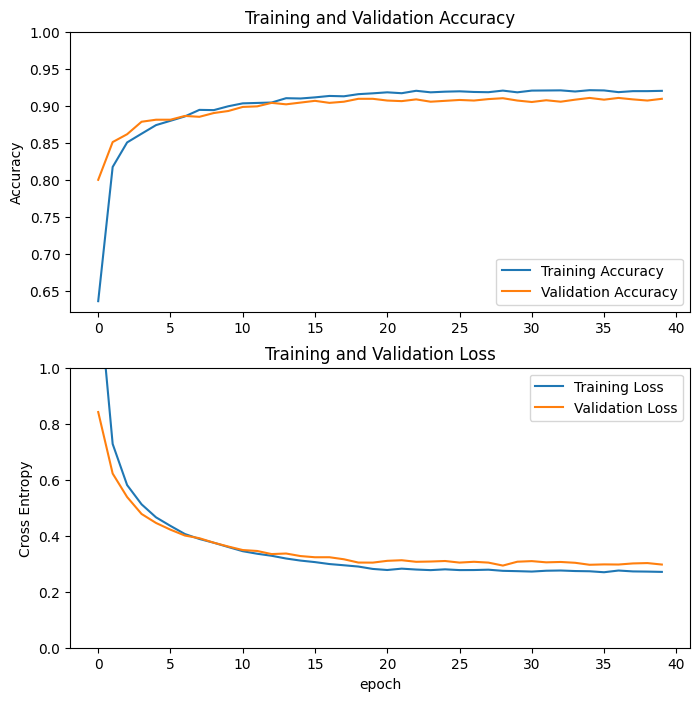

In [14]:
loss_XPT, accuracy_XPT = model_XPT.evaluate(test_dataset)
acc_XPT, val_acc_XPT, loss_XPT, val_loss_XPT = loadHistory('XPTceptionGarbage')
distplayHistory(acc_XPT, val_acc_XPT, loss_XPT, val_loss_XPT)

XCEPTION VERY SLOW TRANSFER

In [15]:
preprocess_input_XVST = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XVST = IMG_SIZE + (3,)
xception_model_XVST = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XVST,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XVST.trainable = False
image_batch_XVST, label_batch_XVST = next(iter(train_dataset))
feature_batch_XVST = xception_model_XVST(image_batch_XVST)
global_average_layer_XVST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XVST = global_average_layer_XVST(feature_batch_XVST)
prediction_layer_XVST = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_XVST = prediction_layer_XVST(feature_batch_average_XVST)
inputs_XVST = tf.keras.Input(shape=(160, 160, 3))
x_XVST = preprocess_input_XVST(inputs_XVST)
x_XVST = xception_model_XVST(x_XVST)
x_XVST = global_average_layer_XVST(x_XVST)
x_XVST = tf.keras.layers.Dropout(0.2)(x_XVST)
outputs_XVST = prediction_layer_XVST(x_XVST)
model_XVST = tf.keras.Model(inputs_XVST, outputs_XVST)
model_XVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XVST = "training_models/Garbage_XVST.ckpt"
checkpoint_dir_XVST = os.path.dirname(checkpoint_path_XVST)
cp_callback_XVST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [16]:
model_XVST.load_weights("training_models/Garbage_XPT.ckpt")
total_epochs_XVST = 30
initial_epochs_XVST = 20
xception_model_XVST.trainable = True
fine_tune_at_XVST = 144
for layer_XVST in xception_model_XVST.layers[:fine_tune_at_XVST]:
  layer_XVST.trainable = False
model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XVST = 1
total_epochs_XVST =  initial_epochs_XVST + fine_tune_epochs_XVST

history_XVST = model_XVST.fit(train_dataset,
                         epochs=total_epochs_XVST,
                         initial_epoch=initial_epochs_XVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XVST])
dumpHistory('XVSTceptionGarbage', history_XVST)
initial_epochs_XVST += fine_tune_epochs_XVST
for i in range (9):
  xception_model_XVST.trainable = True
  fine_tune_at_XVST -= 16
  for layer_XVST in xception_model_XVST.layers[:fine_tune_at_XVST]:
    layer_XVST.trainable = False
  model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XVST = 1
  total_epochs_XVST =  initial_epochs_XVST + fine_tune_epochs_XVST


  history_XVST = model_XVST.fit(train_dataset,
                          epochs=total_epochs_XVST,
                          initial_epoch=initial_epochs_XVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_XVST])
  dumpHistory('XVSTceptionGarbage', history_XVST)
  initial_epochs_XVST+=fine_tune_epochs_XVST

Epoch 21/21
195/195 [==============================] - 165s 830ms/step - loss: 0.2822 - accuracy: 0.9161 - val_loss: 0.3102 - val_accuracy: 0.9069
DUMPED

Epoch 22/22
195/195 [==============================] - 174s 876ms/step - loss: 0.5406 - accuracy: 0.9100 - val_loss: 0.4799 - val_accuracy: 0.9007
DUMPED

Epoch 23/23
195/195 [==============================] - 206s 1s/step - loss: 1.0679 - accuracy: 0.8571 - val_loss: 0.5383 - val_accuracy: 0.8799
DUMPED

Epoch 24/24
195/195 [==============================] - 231s 1s/step - loss: 1.0546 - accuracy: 0.8400 - val_loss: 0.7797 - val_accuracy: 0.8626
DUMPED

Epoch 25/25
195/195 [==============================] - 260s 1s/step - loss: 0.9816 - accuracy: 0.8381 - val_loss: 0.8849 - val_accuracy: 0.8504
DUMPED

Epoch 26/26
195/195 [==============================] - 285s 1s/step - loss: 0.8430 - accuracy: 0.8487 - val_loss: 0.7913 - val_accuracy: 0.8563
DUMPED

Epoch 27/27
195/195 [==============================] - 315s 2s/step - loss: 0.8091

In [17]:
model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XVST = 5
initial_epochs_XVST = total_epochs_XVST
total_epochs_XVST =  initial_epochs_XVST + add_epochs_XVST

history_XVST = model_XVST.fit(train_dataset,
                         epochs=total_epochs_XVST,
                         initial_epoch=initial_epochs_XVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XVST, clr])
initial_epochs_XVST+=add_epochs_XVST
dumpHistory('XVSTceptionGarbage', history_XVST)

Epoch 31/35
195/195 [==============================] - 491s 2s/step - loss: 0.5984 - accuracy: 0.8719 - val_loss: 0.5987 - val_accuracy: 0.8677
Epoch 32/35
195/195 [==============================] - 464s 2s/step - loss: 0.5917 - accuracy: 0.8708 - val_loss: 0.5743 - val_accuracy: 0.8740
Epoch 33/35
195/195 [==============================] - 459s 2s/step - loss: 0.5639 - accuracy: 0.8768 - val_loss: 0.5390 - val_accuracy: 0.8814
Epoch 34/35
195/195 [==============================] - 464s 2s/step - loss: 0.5222 - accuracy: 0.8825 - val_loss: 0.4971 - val_accuracy: 0.8905
Epoch 35/35
195/195 [==============================] - 474s 2s/step - loss: 0.4859 - accuracy: 0.8881 - val_loss: 0.4775 - val_accuracy: 0.8936
DUMPED



9/9 [==============================] - 6s 671ms/step - loss: 0.4746 - accuracy: 0.8906


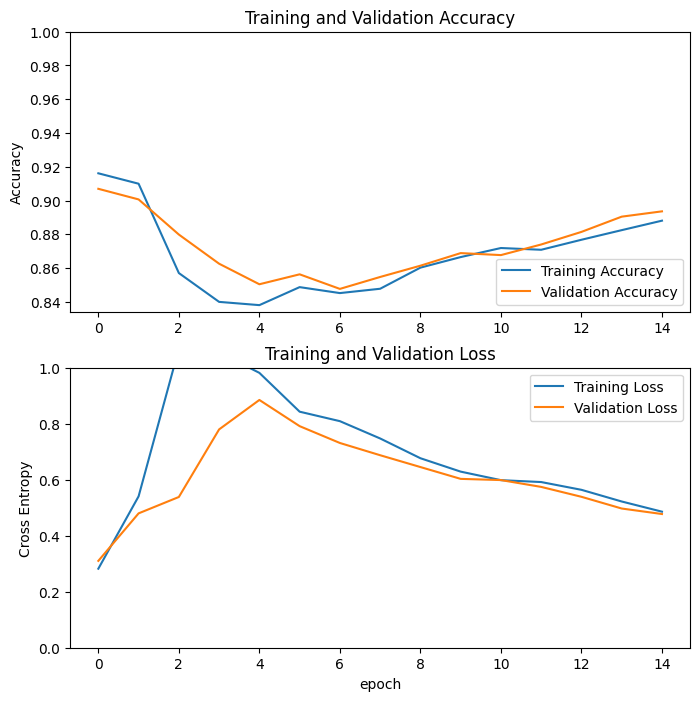

In [18]:
loss_XVST, accuracy_XVST = model_XVST.evaluate(test_dataset)
acc_XVST, val_acc_XVST, loss_XVST, val_loss_XVST = loadHistory('XVSTceptionGarbage')
distplayHistory(acc_XVST, val_acc_XVST, loss_XVST, val_loss_XVST)

VGG-16

VGG-16 NO TRANSFER

In [33]:
preprocess_input_VNT = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VNT = IMG_SIZE + (3,)
xception_model_VNT = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VNT,
                                               include_top=False)
image_batch_VNT, label_batch_VNT = next(iter(train_dataset))
feature_batch_VNT = xception_model_VNT(image_batch_VNT)

global_average_layer_VNT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VNT = global_average_layer_VNT(feature_batch_VNT)

fc1_layer_VNT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VNT = fc1_layer_VNT(feature_batch_average_VNT)

fc2_layer_VNT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VNT = fc2_layer_VNT(fc1_batch_VNT)

prediction_layer_VNT = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_VNT = prediction_layer_VNT(feature_batch_average_VNT)

inputs_VNT = tf.keras.Input(shape=(160, 160, 3))
x_VNT = preprocess_input_VNT(inputs_VNT)
x_VNT = xception_model_VNT(x_VNT)
x_VNT = global_average_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
x_VNT = fc1_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
x_VNT = fc2_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
outputs_VNT = prediction_layer_VNT(x_VNT)
model_VNT = tf.keras.Model(inputs_VNT, outputs_VNT)
model_VNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VNT = "training_models/Garbage_VNT.ckpt"
checkpoint_dir_VNT = os.path.dirname(checkpoint_path_VNT)
cp_callback_VNT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [34]:
total_epochs_VNT = 10
history_VNT = model_VNT.fit(train_dataset,
                         epochs=total_epochs_VNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VNT])
initial_epochs_VNT=total_epochs_VNT
dumpHistory('VNTvgg16Garbage', history_VNT)

Epoch 1/10
195/195 [==============================] - 446s 2s/step - loss: 1.4953 - accuracy: 0.5483 - val_loss: 0.7846 - val_accuracy: 0.7754
Epoch 2/10
195/195 [==============================] - 383s 2s/step - loss: 0.6635 - accuracy: 0.7996 - val_loss: 0.3999 - val_accuracy: 0.8763
Epoch 3/10
195/195 [==============================] - 382s 2s/step - loss: 0.4352 - accuracy: 0.8668 - val_loss: 0.3388 - val_accuracy: 0.8865
Epoch 4/10
195/195 [==============================] - 381s 2s/step - loss: 0.3170 - accuracy: 0.8999 - val_loss: 0.2443 - val_accuracy: 0.9219
Epoch 5/10
195/195 [==============================] - 381s 2s/step - loss: 0.2408 - accuracy: 0.9244 - val_loss: 0.2945 - val_accuracy: 0.9073
Epoch 6/10
195/195 [==============================] - 381s 2s/step - loss: 0.1801 - accuracy: 0.9435 - val_loss: 0.2380 - val_accuracy: 0.9305
Epoch 7/10
195/195 [==============================] - 381s 2s/step - loss: 0.1540 - accuracy: 0.9531 - val_loss: 0.2053 - val_accuracy: 0.9391

In [35]:
model_VNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VNT = 10
total_epochs_VNT =  initial_epochs_VNT + add_epochs_VNT

history_VNT = model_VNT.fit(train_dataset,
                         epochs=total_epochs_VNT,
                         initial_epoch=initial_epochs_VNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VNT, clr])
initial_epochs_VNT+=add_epochs_VNT
dumpHistory('VNTvgg16Garbage', history_VNT)

Epoch 11/20
195/195 [==============================] - 383s 2s/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.2040 - val_accuracy: 0.9505
Epoch 12/20
195/195 [==============================] - 382s 2s/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.2002 - val_accuracy: 0.9513
Epoch 13/20
195/195 [==============================] - 382s 2s/step - loss: 0.0324 - accuracy: 0.9897 - val_loss: 0.1994 - val_accuracy: 0.9497
Epoch 14/20
195/195 [==============================] - 381s 2s/step - loss: 0.0295 - accuracy: 0.9912 - val_loss: 0.2131 - val_accuracy: 0.9533
Epoch 15/20
195/195 [==============================] - 377s 2s/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 0.2020 - val_accuracy: 0.9517
Epoch 16/20
195/195 [==============================] - 378s 2s/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 0.2093 - val_accuracy: 0.9541
Epoch 17/20
195/195 [==============================] - 382s 2s/step - loss: 0.0222 - accuracy: 0.9937 - val_loss: 0.1982 - val_accuracy:

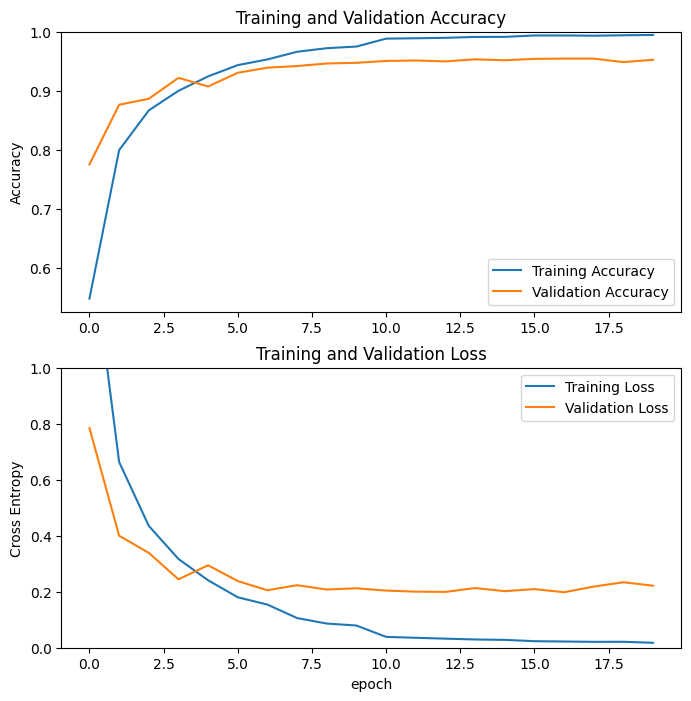

In [36]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('VNTvgg16Garbage')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

In [37]:
loss4, accuracy4 = model_VNT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss4))
print("Test accuracy: {:.4f}".format(accuracy4))

9/9 [==============================] - 5s 539ms/step - loss: 0.1991 - accuracy: 0.9531
Test loss: 0.1991
Test accuracy: 0.9531


VGG16 FAST TRANSFER

In [38]:
preprocess_input_VFT = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VFT = IMG_SIZE + (3,)
vgg16_model_VFT = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VFT,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VFT.trainable = False
image_batch_VFT, label_batch_VFT = next(iter(train_dataset))
feature_batch_VFT = vgg16_model_VFT(image_batch_VFT)

global_average_layer_VFT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VFT = global_average_layer_VFT(feature_batch_VFT)

fc1_layer_VFT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VFT = fc1_layer_VFT(feature_batch_average_VFT)

fc2_layer_VFT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VFT = fc2_layer_VFT(fc1_batch_VFT)

prediction_layer_VFT = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_VFT = prediction_layer_VFT(feature_batch_average_VFT)

inputs_VFT = tf.keras.Input(shape=(160, 160, 3))
x_VFT = preprocess_input_VFT(inputs_VFT)
x_VFT = vgg16_model_VFT(x_VFT)
x_VFT = global_average_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
x_VFT = fc1_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
x_VFT = fc2_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
outputs_VFT = prediction_layer_VFT(x_VFT)
model_VFT = tf.keras.Model(inputs_VFT, outputs_VFT)
model_VFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VFT = "training_models/Garbage_VFT.ckpt"
checkpoint_dir_VFT = os.path.dirname(checkpoint_path_VFT)
cp_callback_VFT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VFT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [39]:
total_epochs_VFT = 5
history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT])
initial_epochs_VFT=total_epochs_VFT
dumpHistory('VFTvgg16Garbage', history_VFT)

Epoch 1/5
195/195 [==============================] - 130s 661ms/step - loss: 1.4746 - accuracy: 0.6733 - val_loss: 0.4411 - val_accuracy: 0.8665
Epoch 2/5
195/195 [==============================] - 129s 660ms/step - loss: 0.7304 - accuracy: 0.7950 - val_loss: 0.3598 - val_accuracy: 0.8861
Epoch 3/5
195/195 [==============================] - 129s 660ms/step - loss: 0.5883 - accuracy: 0.8237 - val_loss: 0.3342 - val_accuracy: 0.8944
Epoch 4/5
195/195 [==============================] - 129s 660ms/step - loss: 0.5200 - accuracy: 0.8437 - val_loss: 0.3090 - val_accuracy: 0.9026
Epoch 5/5
195/195 [==============================] - 129s 660ms/step - loss: 0.4582 - accuracy: 0.8572 - val_loss: 0.2983 - val_accuracy: 0.9077
DUMPED



In [40]:
vgg16_model_VFT.trainable = True
fine_tune_at_VFT = 16
for layer_VFT in vgg16_model_VFT.layers[:fine_tune_at_VFT]:
  layer_VFT.trainable = False
model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VFT = 1
total_epochs_VFT =  initial_epochs_VFT + fine_tune_epochs_VFT

history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=initial_epochs_VFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT])
dumpHistory('VFTvgg16Garbage', history_VFT)
initial_epochs_VFT += fine_tune_epochs_VFT
for i in range (4):
  vgg16_model_VFT.trainable = True
  fine_tune_at_VFT -= 4
  for layer_VFT in vgg16_model_VFT.layers[:fine_tune_at_VFT]:
    layer_VFT.trainable = False
  model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VFT = 1
  total_epochs_VFT =  initial_epochs_VFT + fine_tune_epochs_VFT


  history_VFT = model_VFT.fit(train_dataset,
                          epochs=total_epochs_VFT,
                          initial_epoch=initial_epochs_VFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_VFT])
  dumpHistory('VFTvgg16Garbage', history_VFT)
  initial_epochs_VFT+=fine_tune_epochs_VFT


Epoch 6/6
195/195 [==============================] - 141s 717ms/step - loss: 0.4338 - accuracy: 0.8615 - val_loss: 0.2817 - val_accuracy: 0.9148
DUMPED

Epoch 7/7
195/195 [==============================] - 175s 892ms/step - loss: 0.3837 - accuracy: 0.8776 - val_loss: 0.2545 - val_accuracy: 0.9195
DUMPED

Epoch 8/8
195/195 [==============================] - 229s 1s/step - loss: 0.3356 - accuracy: 0.8902 - val_loss: 0.2380 - val_accuracy: 0.9266
DUMPED

Epoch 9/9
195/195 [==============================] - 307s 2s/step - loss: 0.2949 - accuracy: 0.9036 - val_loss: 0.2301 - val_accuracy: 0.9266
DUMPED

Epoch 10/10
195/195 [==============================] - 383s 2s/step - loss: 0.2745 - accuracy: 0.9122 - val_loss: 0.2252 - val_accuracy: 0.9282
DUMPED



In [41]:
model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VFT = 10
total_epochs_VFT =  initial_epochs_VFT + add_epochs_VFT

history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=initial_epochs_VFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT, clr])
initial_epochs_VFT+=add_epochs_VFT
dumpHistory('VFTvgg16Garbage', history_VFT)

Epoch 11/20
195/195 [==============================] - 383s 2s/step - loss: 0.2464 - accuracy: 0.9174 - val_loss: 0.2107 - val_accuracy: 0.9356
Epoch 12/20
195/195 [==============================] - 382s 2s/step - loss: 0.2355 - accuracy: 0.9214 - val_loss: 0.2166 - val_accuracy: 0.9329
Epoch 13/20
195/195 [==============================] - 382s 2s/step - loss: 0.2303 - accuracy: 0.9237 - val_loss: 0.2045 - val_accuracy: 0.9321
Epoch 14/20
195/195 [==============================] - 378s 2s/step - loss: 0.2230 - accuracy: 0.9254 - val_loss: 0.2022 - val_accuracy: 0.9407
Epoch 15/20
195/195 [==============================] - 382s 2s/step - loss: 0.1986 - accuracy: 0.9341 - val_loss: 0.1919 - val_accuracy: 0.9411
Epoch 16/20
195/195 [==============================] - 382s 2s/step - loss: 0.1705 - accuracy: 0.9418 - val_loss: 0.1926 - val_accuracy: 0.9395
Epoch 17/20
195/195 [==============================] - 382s 2s/step - loss: 0.1585 - accuracy: 0.9462 - val_loss: 0.1847 - val_accuracy:

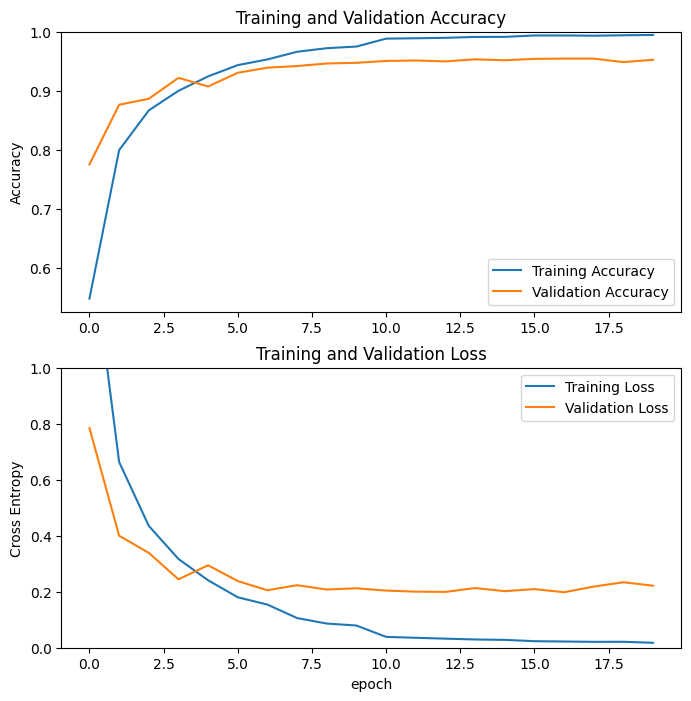

9/9 [==============================] - 5s 540ms/step - loss: 0.1947 - accuracy: 0.9392
Test loss: 0.1947
Test accuracy: 0.9392


In [42]:
acc_VFT, val_acc_VFT, loss_VFT, val_loss_VFT = loadHistory('VNTvgg16Garbage')
distplayHistory(acc_VFT, val_acc_VFT, loss_VFT, val_loss_VFT)
loss5, accuracy5 = model_VFT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss5))
print("Test accuracy: {:.4f}".format(accuracy5))

VGG16 SLOW TRANSFER

In [14]:
preprocess_input_VST = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VST = IMG_SIZE + (3,)
vgg16_model_VST = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VST,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VST.trainable = False
image_batch_VST, label_batch_VST = next(iter(train_dataset))
feature_batch_VST = vgg16_model_VST(image_batch_VST)

global_average_layer_VST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VST = global_average_layer_VST(feature_batch_VST)

fc1_layer_VST = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VST = fc1_layer_VST(feature_batch_average_VST)

fc2_layer_VST = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VST = fc2_layer_VST(fc1_batch_VST)

prediction_layer_VST = tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_VST = prediction_layer_VST(feature_batch_average_VST)

inputs_VST = tf.keras.Input(shape=(160, 160, 3))
x_VST = preprocess_input_VST(inputs_VST)
x_VST = vgg16_model_VST(x_VST)
x_VST = global_average_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
x_VST = fc1_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
x_VST = fc2_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
outputs_VST = prediction_layer_VST(x_VST)
model_VST = tf.keras.Model(inputs_VST, outputs_VST)
model_VST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VST = "training_models/Garbage_VST.ckpt"
checkpoint_dir_VST = os.path.dirname(checkpoint_path_VST)
cp_callback_VST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [44]:
total_epochs_VST = 10
history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST])
initial_epochs_VST=total_epochs_VST
dumpHistory('VSTvgg16Garbage', history_VST)

Epoch 1/10
195/195 [==============================] - 134s 669ms/step - loss: 1.4657 - accuracy: 0.6725 - val_loss: 0.4373 - val_accuracy: 0.8677
Epoch 2/10
195/195 [==============================] - 131s 668ms/step - loss: 0.7172 - accuracy: 0.7984 - val_loss: 0.3405 - val_accuracy: 0.8940
Epoch 3/10
195/195 [==============================] - 131s 669ms/step - loss: 0.6051 - accuracy: 0.8230 - val_loss: 0.3235 - val_accuracy: 0.9003
Epoch 4/10
195/195 [==============================] - 131s 669ms/step - loss: 0.5156 - accuracy: 0.8446 - val_loss: 0.2993 - val_accuracy: 0.9062
Epoch 5/10
195/195 [==============================] - 131s 669ms/step - loss: 0.4812 - accuracy: 0.8530 - val_loss: 0.2905 - val_accuracy: 0.9026
Epoch 6/10
195/195 [==============================] - 131s 668ms/step - loss: 0.4340 - accuracy: 0.8651 - val_loss: 0.2764 - val_accuracy: 0.9081
Epoch 7/10
195/195 [==============================] - 131s 668ms/step - loss: 0.4118 - accuracy: 0.8708 - val_loss: 0.2733 -

In [45]:
vgg16_model_VST.trainable = True
fine_tune_at_VST = 16
for layer_VST in vgg16_model_VST.layers[:fine_tune_at_VST]:
  layer_VST.trainable = False
model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VST = 2
total_epochs_VST =  initial_epochs_VST + fine_tune_epochs_VST

history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=initial_epochs_VST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST])
dumpHistory('VSTvgg16Garbage', history_VST)
initial_epochs_VST += fine_tune_epochs_VST
for i in range (4):
  vgg16_model_VST.trainable = True
  fine_tune_at_VST -= 4
  for layer_VST in vgg16_model_VST.layers[:fine_tune_at_VST]:
    layer_VST.trainable = False
  model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VST = 2
  total_epochs_VST =  initial_epochs_VST + fine_tune_epochs_VST


  history_VST = model_VST.fit(train_dataset,
                          epochs=total_epochs_VST,
                          initial_epoch=initial_epochs_VST,
                          validation_data=validation_dataset, callbacks=[cp_callback_VST])
  dumpHistory('VSTvgg16Garbage', history_VST)
  initial_epochs_VST+=fine_tune_epochs_VST


Epoch 11/12
195/195 [==============================] - 143s 725ms/step - loss: 0.3289 - accuracy: 0.8951 - val_loss: 0.2465 - val_accuracy: 0.9203
Epoch 12/12
195/195 [==============================] - 141s 723ms/step - loss: 0.3051 - accuracy: 0.8987 - val_loss: 0.2326 - val_accuracy: 0.9238
DUMPED

Epoch 13/14
195/195 [==============================] - 177s 899ms/step - loss: 0.2796 - accuracy: 0.9099 - val_loss: 0.2255 - val_accuracy: 0.9278
Epoch 14/14
195/195 [==============================] - 176s 899ms/step - loss: 0.2612 - accuracy: 0.9131 - val_loss: 0.2189 - val_accuracy: 0.9305
DUMPED

Epoch 15/16
195/195 [==============================] - 227s 1s/step - loss: 0.2332 - accuracy: 0.9209 - val_loss: 0.2125 - val_accuracy: 0.9317
Epoch 16/16
195/195 [==============================] - 226s 1s/step - loss: 0.2233 - accuracy: 0.9261 - val_loss: 0.1986 - val_accuracy: 0.9388
DUMPED

Epoch 17/18
195/195 [==============================] - 308s 2s/step - loss: 0.1960 - accuracy: 0.933

In [46]:
model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VST = 5
total_epochs_VST =  initial_epochs_VST + add_epochs_VST

history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=initial_epochs_VST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST, clr])
initial_epochs_VST+=add_epochs_VST
dumpHistory('VSTvgg16Garbage', history_VST)

Epoch 21/25
195/195 [==============================] - 385s 2s/step - loss: 0.1535 - accuracy: 0.9477 - val_loss: 0.1873 - val_accuracy: 0.9454
Epoch 22/25
195/195 [==============================] - 384s 2s/step - loss: 0.1473 - accuracy: 0.9498 - val_loss: 0.1857 - val_accuracy: 0.9474
Epoch 23/25
195/195 [==============================] - 384s 2s/step - loss: 0.1380 - accuracy: 0.9509 - val_loss: 0.1768 - val_accuracy: 0.9521
Epoch 24/25
195/195 [==============================] - 384s 2s/step - loss: 0.1345 - accuracy: 0.9550 - val_loss: 0.1877 - val_accuracy: 0.9431
Epoch 25/25
195/195 [==============================] - 380s 2s/step - loss: 0.1380 - accuracy: 0.9529 - val_loss: 0.1817 - val_accuracy: 0.9442
DUMPED



9/9 [==============================] - 26s 586ms/step - loss: 0.2104 - accuracy: 0.9392


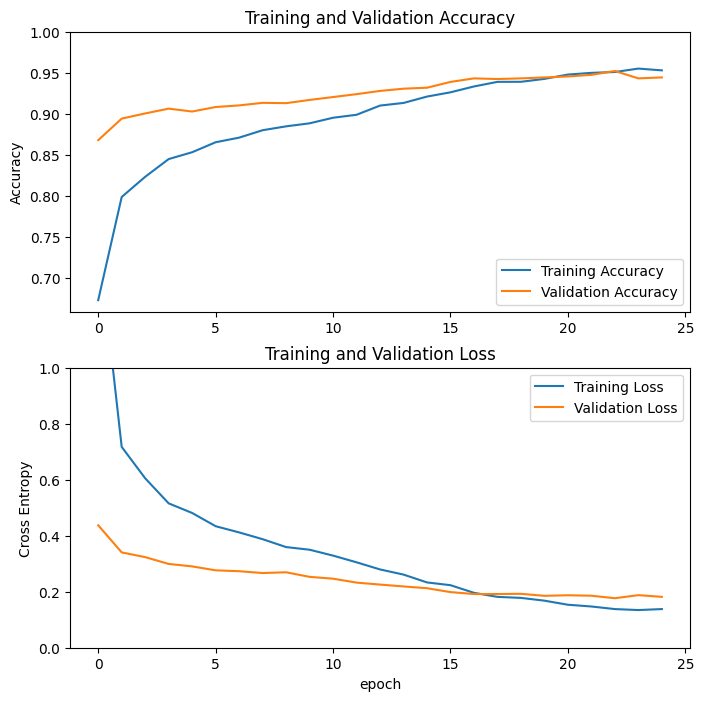

In [15]:
model_VST.load_weights("training_models/Garbage_VST.ckpt")
loss_VST, accuracy_VST = model_VST.evaluate(test_dataset)
acc_VST, val_acc_VST, loss_VST, val_loss_VST = loadHistory('VSTvgg16Garbage')
distplayHistory(acc_VST, val_acc_VST, loss_VST, val_loss_VST)

VGG PARTICAL TRANSFER

In [19]:
preprocess_input_VPT= tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VPT= IMG_SIZE + (3,)
vgg16_model_VPT= tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VPT,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VPT.trainable = False
image_batch_VPT, label_batch_VPT= next(iter(train_dataset))
feature_batch_VPT= vgg16_model_VPT(image_batch_VPT)

global_average_layer_VPT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VPT= global_average_layer_VPT(feature_batch_VPT)

fc1_layer_VPT= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VPT= fc1_layer_VPT(feature_batch_average_VPT)

fc2_layer_VPT= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VPT= fc2_layer_VPT(fc1_batch_VPT)

prediction_layer_VPT= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_VPT= prediction_layer_VPT(feature_batch_average_VPT)

inputs_VPT= tf.keras.Input(shape=(160, 160, 3))
x_VPT= preprocess_input_VPT(inputs_VPT)
x_VPT= vgg16_model_VPT(x_VPT)
x_VPT= global_average_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
x_VPT= fc1_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
x_VPT= fc2_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
outputs_VPT= prediction_layer_VPT(x_VPT)
model_VPT= tf.keras.Model(inputs_VPT, outputs_VPT)
model_VPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VPT= "training_models/Garbage_VPT.ckpt"
checkpoint_dir_VPT= os.path.dirname(checkpoint_path_VPT)
cp_callback_VPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VPT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [20]:
total_epochs_VPT = 20
history_VPT = model_VPT.fit(train_dataset,
                         epochs=total_epochs_VPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VPT])
initial_epochs_VPT=total_epochs_VPT
dumpHistory('VPTvgg16Garbage', history_VPT)

Epoch 1/20
195/195 [==============================] - 189s 871ms/step - loss: 1.4465 - accuracy: 0.6792 - val_loss: 0.4283 - val_accuracy: 0.8708
Epoch 2/20
195/195 [==============================] - 136s 698ms/step - loss: 0.7326 - accuracy: 0.7973 - val_loss: 0.3755 - val_accuracy: 0.8850
Epoch 3/20
195/195 [==============================] - 136s 697ms/step - loss: 0.5982 - accuracy: 0.8230 - val_loss: 0.3428 - val_accuracy: 0.8952
Epoch 4/20
195/195 [==============================] - 136s 697ms/step - loss: 0.5141 - accuracy: 0.8443 - val_loss: 0.3055 - val_accuracy: 0.9046
Epoch 5/20
195/195 [==============================] - 131s 669ms/step - loss: 0.4645 - accuracy: 0.8571 - val_loss: 0.2966 - val_accuracy: 0.9081
Epoch 6/20
195/195 [==============================] - 129s 662ms/step - loss: 0.4290 - accuracy: 0.8653 - val_loss: 0.2859 - val_accuracy: 0.9195
Epoch 7/20
195/195 [==============================] - 128s 657ms/step - loss: 0.4060 - accuracy: 0.8709 - val_loss: 0.2769 -

In [21]:
checkpoint_path_VPT= "training_models/Garbage_VFPT.ckpt"
checkpoint_dir_VPT= os.path.dirname(checkpoint_path_VPT)
cp_callback_VPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VPT,
                                                 save_weights_only=True,
                                                 verbose=0)
total_epochs_VPT = 40
history_VPT = model_VPT.fit(train_dataset,
                         epochs=total_epochs_VPT,
                         initial_epoch=initial_epochs_VPT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VPT, clr])
dumpHistory('VPTvgg16Garbage', history_VPT)

Epoch 21/40
195/195 [==============================] - 138s 705ms/step - loss: 0.2578 - accuracy: 0.9140 - val_loss: 0.2215 - val_accuracy: 0.9372
Epoch 22/40
195/195 [==============================] - 138s 709ms/step - loss: 0.2498 - accuracy: 0.9176 - val_loss: 0.2241 - val_accuracy: 0.9352
Epoch 23/40
195/195 [==============================] - 139s 712ms/step - loss: 0.2552 - accuracy: 0.9172 - val_loss: 0.2294 - val_accuracy: 0.9329
Epoch 24/40
195/195 [==============================] - 139s 711ms/step - loss: 0.2400 - accuracy: 0.9197 - val_loss: 0.2279 - val_accuracy: 0.9336
Epoch 25/40
195/195 [==============================] - 139s 712ms/step - loss: 0.2584 - accuracy: 0.9140 - val_loss: 0.2242 - val_accuracy: 0.9340
Epoch 26/40
195/195 [==============================] - 139s 711ms/step - loss: 0.2432 - accuracy: 0.9205 - val_loss: 0.2240 - val_accuracy: 0.9344
Epoch 27/40
195/195 [==============================] - 139s 710ms/step - loss: 0.2394 - accuracy: 0.9202 - val_loss: 0

9/9 [==============================] - 5s 538ms/step - loss: 0.2267 - accuracy: 0.9375


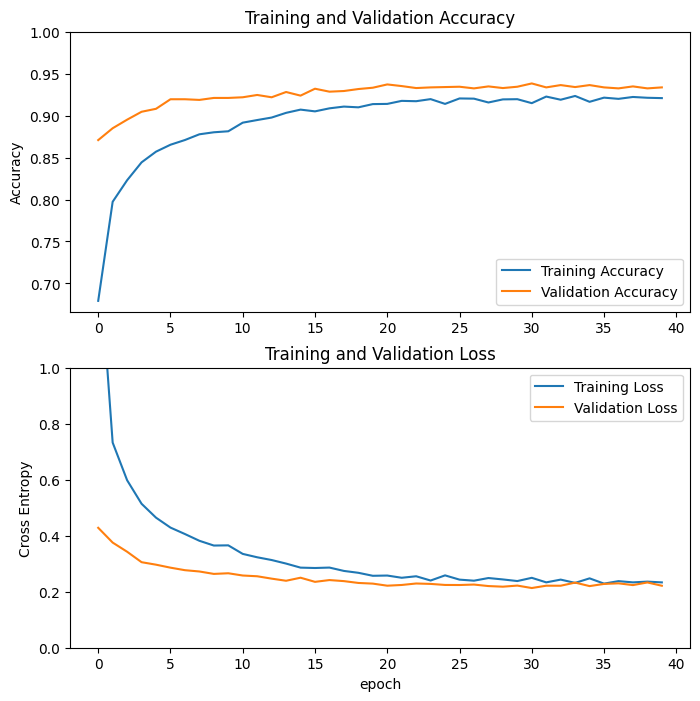

In [22]:
model_VPT.load_weights("training_models/Garbage_VPT.ckpt")
loss_VPT, accuracy_VPT = model_VPT.evaluate(test_dataset)
acc_VPT, val_acc_VPT, loss_VPT, val_loss_VPT = loadHistory('VPTvgg16Garbage')
distplayHistory(acc_VPT, val_acc_VPT, loss_VPT, val_loss_VPT)

VGG16 VERY SLOW TRANSFER

In [23]:
preprocess_input_VVST= tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VVST= IMG_SIZE + (3,)
vgg16_model_VVST= tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VVST,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VVST.trainable = False
image_batch_VVST, label_batch_VVST= next(iter(train_dataset))
feature_batch_VVST= vgg16_model_VVST(image_batch_VVST)

global_average_layer_VVST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VVST= global_average_layer_VVST(feature_batch_VVST)

fc1_layer_VVST= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_VVST= fc1_layer_VVST(feature_batch_average_VVST)

fc2_layer_VVST= tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc2_batch_VVST= fc2_layer_VVST(fc1_batch_VVST)

prediction_layer_VVST= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_VVST= prediction_layer_VVST(feature_batch_average_VVST)

inputs_VVST= tf.keras.Input(shape=(160, 160, 3))
x_VVST= preprocess_input_VVST(inputs_VVST)
x_VVST= vgg16_model_VVST(x_VVST)
x_VVST= global_average_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
x_VVST= fc1_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
x_VVST= fc2_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
outputs_VVST= prediction_layer_VVST(x_VVST)
model_VVST= tf.keras.Model(inputs_VVST, outputs_VVST)
model_VVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VVST= "training_models/Garbage_VVST.ckpt"
checkpoint_dir_VVST= os.path.dirname(checkpoint_path_VVST)
cp_callback_VVST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [24]:
model_VVST.load_weights("training_models/Garbage_VPT.ckpt")
initial_epochs_VVST=20
vgg16_model_VVST.trainable = True
fine_tune_at_VVST = 18
for layer_VVST in vgg16_model_VVST.layers[:fine_tune_at_VVST]:
  layer_VVST.trainable = False
model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VVST = 1
total_epochs_VVST =  initial_epochs_VVST + fine_tune_epochs_VVST

history_VVST = model_VVST.fit(train_dataset,
                         epochs=total_epochs_VVST,
                         initial_epoch=initial_epochs_VVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VVST])
dumpHistory('VVSTvgg16Garbage', history_VVST)
initial_epochs_VVST += fine_tune_epochs_VVST
print(len(model_VVST.trainable_variables))
for i in range (9):
  vgg16_model_VVST.trainable = True
  fine_tune_at_VVST -= 2
  for layer_VVST in vgg16_model_VVST.layers[:fine_tune_at_VVST]:
    layer_VVST.trainable = False
  model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VVST = 1
  total_epochs_VVST =  initial_epochs_VVST + fine_tune_epochs_VVST


  history_VVST = model_VVST.fit(train_dataset,
                          epochs=total_epochs_VVST,
                          initial_epoch=initial_epochs_VVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_VVST])
  dumpHistory('VVSTvgg16Garbage', history_VVST)
  initial_epochs_VVST+=fine_tune_epochs_VVST


Epoch 21/21
195/195 [==============================] - 141s 716ms/step - loss: 0.2523 - accuracy: 0.9141 - val_loss: 0.2200 - val_accuracy: 0.9360
DUMPED

6
Epoch 22/22
195/195 [==============================] - 153s 778ms/step - loss: 0.2429 - accuracy: 0.9193 - val_loss: 0.2266 - val_accuracy: 0.9321
DUMPED

Epoch 23/23
195/195 [==============================] - 159s 811ms/step - loss: 0.2251 - accuracy: 0.9218 - val_loss: 0.2193 - val_accuracy: 0.9329
DUMPED

Epoch 24/24
195/195 [==============================] - 192s 972ms/step - loss: 0.2182 - accuracy: 0.9279 - val_loss: 0.2116 - val_accuracy: 0.9384
DUMPED

Epoch 25/25
195/195 [==============================] - 204s 1s/step - loss: 0.2005 - accuracy: 0.9319 - val_loss: 0.2055 - val_accuracy: 0.9415
DUMPED

Epoch 26/26
195/195 [==============================] - 244s 1s/step - loss: 0.1835 - accuracy: 0.9375 - val_loss: 0.2014 - val_accuracy: 0.9384
DUMPED

Epoch 27/27
195/195 [==============================] - 250s 1s/step - loss

In [25]:
model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VVST = 5
total_epochs_VVST =  initial_epochs_VVST + add_epochs_VVST

history_VVST = model_VVST.fit(train_dataset,
                         epochs=total_epochs_VVST,
                         initial_epoch=initial_epochs_VVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VVST, clr])
initial_epochs_VVST+=add_epochs_VVST
dumpHistory('VVSTvgg16Garbage', history_VVST)

Epoch 31/35
195/195 [==============================] - 406s 2s/step - loss: 0.1367 - accuracy: 0.9530 - val_loss: 0.1850 - val_accuracy: 0.9399
Epoch 32/35
195/195 [==============================] - 403s 2s/step - loss: 0.1155 - accuracy: 0.9602 - val_loss: 0.1732 - val_accuracy: 0.9450
Epoch 33/35
195/195 [==============================] - 404s 2s/step - loss: 0.1125 - accuracy: 0.9619 - val_loss: 0.1689 - val_accuracy: 0.9474
Epoch 34/35
195/195 [==============================] - 404s 2s/step - loss: 0.1138 - accuracy: 0.9603 - val_loss: 0.1735 - val_accuracy: 0.9482
Epoch 35/35
195/195 [==============================] - 383s 2s/step - loss: 0.1176 - accuracy: 0.9609 - val_loss: 0.1747 - val_accuracy: 0.9521
DUMPED



9/9 [==============================] - 5s 505ms/step - loss: 0.2025 - accuracy: 0.9514


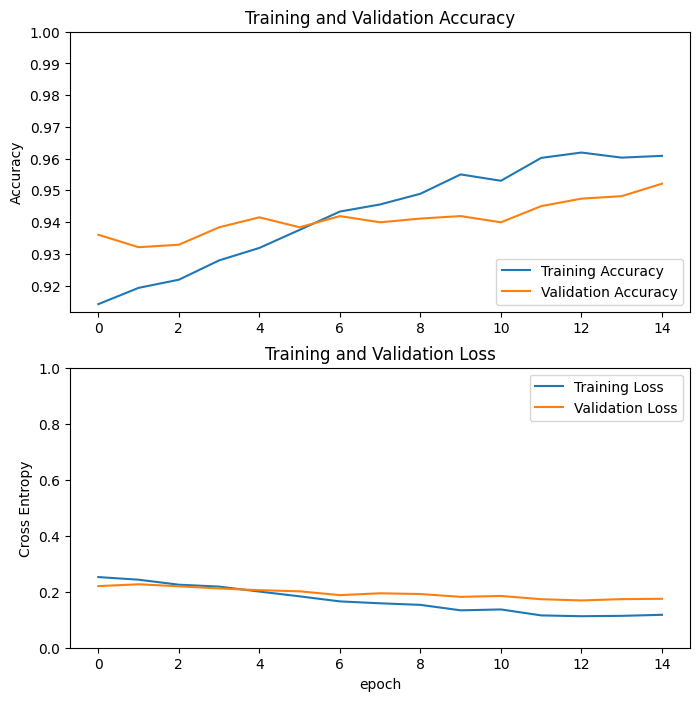

In [26]:
loss_VVST, accuracy_VVST = model_VVST.evaluate(test_dataset)
acc_VVST, val_acc_VVST, loss_VVST, val_loss_VVST = loadHistory('VVSTvgg16Garbage')
distplayHistory(acc_VVST, val_acc_VVST, loss_VVST, val_loss_VVST)

MOBILENET NO TRANSFER

In [16]:
preprocess_input_MNT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MNT= IMG_SIZE + (3,)
mobilenet_model_MNT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MNT,
                                               include_top=False)
image_batch_MNT, label_batch_MNT= next(iter(train_dataset))
feature_batch_MNT= mobilenet_model_MNT(image_batch_MNT)

global_average_layer_MNT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MNT= global_average_layer_MNT(feature_batch_MNT)

fc1_layer_MNT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MNT= fc1_layer_MNT(feature_batch_average_MNT)

prediction_layer_MNT= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_MNT= prediction_layer_MNT(fc1_batch_MNT)

inputs_MNT= tf.keras.Input(shape=(160, 160, 3))
x_MNT= preprocess_input_MNT(inputs_MNT)
x_MNT= mobilenet_model_MNT(x_MNT)
x_MNT= global_average_layer_MNT(x_MNT)
x_MNT= tf.keras.layers.Dropout(0.2)(x_MNT)
x_MNT= fc1_layer_MNT(x_MNT)
x_MNT= tf.keras.layers.Dropout(0.2)(x_MNT)
outputs_MNT= prediction_layer_MNT(x_MNT)
model_MNT= tf.keras.Model(inputs_MNT, outputs_MNT)
model_MNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MNT= "training_models/Garbage_MNT.ckpt"
checkpoint_dir_MNT= os.path.dirname(checkpoint_path_MNT)
cp_callback_MNT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [48]:
total_epochs_MNT = 10
history_MNT = model_MNT.fit(train_dataset,
                         epochs=total_epochs_MNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MNT])
initial_epochs_MNT=total_epochs_MNT
dumpHistory('MNTmobnetGarbage', history_MNT)

Epoch 1/10
195/195 [==============================] - 142s 703ms/step - loss: 1.0017 - accuracy: 0.6941 - val_loss: 0.4444 - val_accuracy: 0.8665
Epoch 2/10
195/195 [==============================] - 133s 678ms/step - loss: 0.4300 - accuracy: 0.8654 - val_loss: 0.2952 - val_accuracy: 0.9089
Epoch 3/10
195/195 [==============================] - 133s 678ms/step - loss: 0.2917 - accuracy: 0.9114 - val_loss: 0.2370 - val_accuracy: 0.9262
Epoch 4/10
195/195 [==============================] - 132s 677ms/step - loss: 0.2282 - accuracy: 0.9301 - val_loss: 0.1921 - val_accuracy: 0.9384
Epoch 5/10
195/195 [==============================] - 133s 678ms/step - loss: 0.1778 - accuracy: 0.9433 - val_loss: 0.1704 - val_accuracy: 0.9442
Epoch 6/10
195/195 [==============================] - 132s 677ms/step - loss: 0.1520 - accuracy: 0.9518 - val_loss: 0.1647 - val_accuracy: 0.9454
Epoch 7/10
195/195 [==============================] - 133s 678ms/step - loss: 0.1240 - accuracy: 0.9610 - val_loss: 0.1600 -

In [49]:
model_MNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MNT = 10
total_epochs_MNT =  initial_epochs_MNT + add_epochs_MNT

history_MNT = model_MNT.fit(train_dataset,
                         epochs=total_epochs_MNT,
                         initial_epoch=initial_epochs_MNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MNT, clr])
initial_epochs_MNT+=add_epochs_MNT
dumpHistory('MNTmobnetGarbage', history_MNT)

Epoch 11/20
195/195 [==============================] - 135s 678ms/step - loss: 0.0707 - accuracy: 0.9813 - val_loss: 0.1384 - val_accuracy: 0.9548
Epoch 12/20
195/195 [==============================] - 132s 677ms/step - loss: 0.0670 - accuracy: 0.9812 - val_loss: 0.1366 - val_accuracy: 0.9552
Epoch 13/20
195/195 [==============================] - 132s 677ms/step - loss: 0.0648 - accuracy: 0.9820 - val_loss: 0.1428 - val_accuracy: 0.9537
Epoch 14/20
195/195 [==============================] - 132s 676ms/step - loss: 0.0666 - accuracy: 0.9824 - val_loss: 0.1369 - val_accuracy: 0.9548
Epoch 15/20
195/195 [==============================] - 132s 676ms/step - loss: 0.0719 - accuracy: 0.9796 - val_loss: 0.1467 - val_accuracy: 0.9521
Epoch 16/20
195/195 [==============================] - 132s 677ms/step - loss: 0.0634 - accuracy: 0.9831 - val_loss: 0.1429 - val_accuracy: 0.9556
Epoch 17/20
195/195 [==============================] - 132s 676ms/step - loss: 0.0611 - accuracy: 0.9834 - val_loss: 0

9/9 [==============================] - 3s 235ms/step - loss: 0.1633 - accuracy: 0.9410


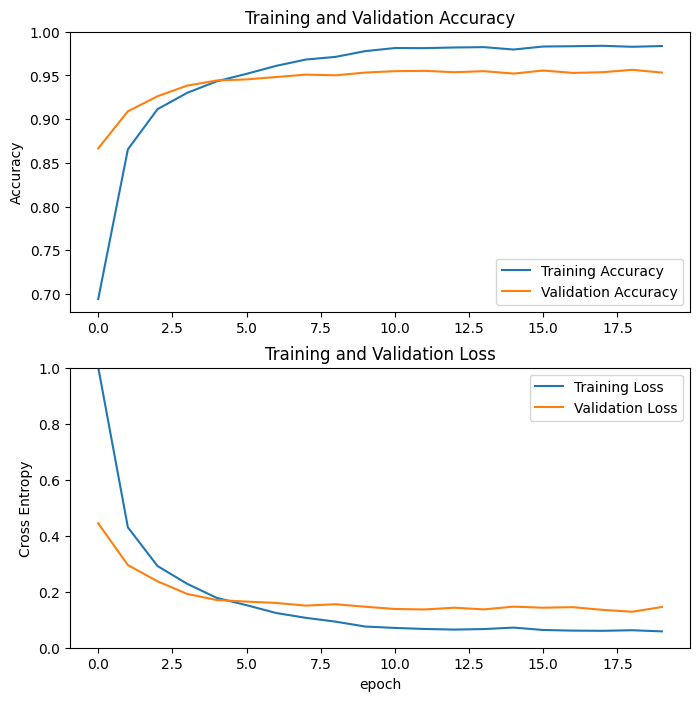

In [18]:
model_MNT.load_weights("training_models/Garbage_MNT.ckpt")
loss_MNT, accuracy_MNT = model_MNT.evaluate(test_dataset)
acc_MNT, val_acc_MNT, loss_MNT, val_loss_MNT = loadHistory('MNTmobnetGarbage')
distplayHistory(acc_MNT, val_acc_MNT, loss_MNT, val_loss_MNT)

MOBILENET FAST TRANSFER

In [27]:
preprocess_input_MFT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MFT= IMG_SIZE + (3,)
mobilenet_model_MFT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MFT,
                                               include_top=False)
mobilenet_model_MFT.trainable = False
image_batch_MFT, label_batch_MFT= next(iter(train_dataset))
feature_batch_MFT= mobilenet_model_MFT(image_batch_MFT)

global_average_layer_MFT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MFT= global_average_layer_MFT(feature_batch_MFT)

fc1_layer_MFT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MFT= fc1_layer_MFT(feature_batch_average_MFT)

prediction_layer_MFT= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_MFT= prediction_layer_MFT(fc1_batch_MFT)

inputs_MFT= tf.keras.Input(shape=(160, 160, 3))
x_MFT= preprocess_input_MFT(inputs_MFT)
x_MFT= mobilenet_model_MFT(x_MFT)
x_MFT= global_average_layer_MFT(x_MFT)
x_MFT= tf.keras.layers.Dropout(0.2)(x_MFT)
x_MFT= fc1_layer_MFT(x_MFT)
x_MFT= tf.keras.layers.Dropout(0.2)(x_MFT)
outputs_MFT= prediction_layer_MFT(x_MFT)
model_MFT= tf.keras.Model(inputs_MFT, outputs_MFT)
model_MFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MFT= "training_models/Garbage_MFT.ckpt"
checkpoint_dir_MFT= os.path.dirname(checkpoint_path_MFT)
cp_callback_MFT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MFT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [ ]:
#print("Number of layers in the base model: ", len(mobilenet_model_MFT.layers))

Number of layers in the base model:  86


In [28]:
total_epochs_MFT = 5
history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT])
initial_epochs_MFT=total_epochs_MFT
dumpHistory('MFTmobnetGarbage', history_MFT)

Epoch 1/5
195/195 [==============================] - 63s 296ms/step - loss: 1.1794 - accuracy: 0.6410 - val_loss: 0.6088 - val_accuracy: 0.8324
Epoch 2/5
195/195 [==============================] - 53s 268ms/step - loss: 0.6158 - accuracy: 0.8138 - val_loss: 0.4491 - val_accuracy: 0.8649
Epoch 3/5
195/195 [==============================] - 53s 268ms/step - loss: 0.4977 - accuracy: 0.8452 - val_loss: 0.3755 - val_accuracy: 0.8838
Epoch 4/5
195/195 [==============================] - 53s 268ms/step - loss: 0.4227 - accuracy: 0.8651 - val_loss: 0.3444 - val_accuracy: 0.8952
Epoch 5/5
195/195 [==============================] - 53s 269ms/step - loss: 0.3838 - accuracy: 0.8791 - val_loss: 0.3133 - val_accuracy: 0.9046
DUMPED



In [29]:
mobilenet_model_MFT.trainable = True
fine_tune_at_MFT = 72
for layer_MFT in mobilenet_model_MFT.layers[:fine_tune_at_MFT]:
  layer_MFT.trainable = False
model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MFT = 1
total_epochs_MFT =  initial_epochs_MFT + fine_tune_epochs_MFT

history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=initial_epochs_MFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT])
dumpHistory('MFTmobnetGarbage', history_MFT)
initial_epochs_MFT += fine_tune_epochs_MFT
for i in range (4):
  mobilenet_model_MFT.trainable = True
  fine_tune_at_MFT -= 18
  for layer_MFT in mobilenet_model_MFT.layers[:fine_tune_at_MFT]:
    layer_MFT.trainable = False
  model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MFT = 1
  total_epochs_MFT =  initial_epochs_MFT + fine_tune_epochs_MFT


  history_MFT = model_MFT.fit(train_dataset,
                          epochs=total_epochs_MFT,
                          initial_epoch=initial_epochs_MFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_MFT])
  dumpHistory('MFTmobnetGarbage', history_MFT)
  initial_epochs_MFT+=fine_tune_epochs_MFT


Epoch 6/6
195/195 [==============================] - 62s 303ms/step - loss: 0.4461 - accuracy: 0.8567 - val_loss: 0.3267 - val_accuracy: 0.8940
DUMPED

Epoch 7/7
195/195 [==============================] - 71s 352ms/step - loss: 0.4400 - accuracy: 0.8598 - val_loss: 0.3319 - val_accuracy: 0.9015
DUMPED

Epoch 8/8
195/195 [==============================] - 80s 397ms/step - loss: 0.4284 - accuracy: 0.8618 - val_loss: 0.3266 - val_accuracy: 0.9050
DUMPED

Epoch 9/9
195/195 [==============================] - 101s 499ms/step - loss: 0.4190 - accuracy: 0.8689 - val_loss: 0.3239 - val_accuracy: 0.9038
DUMPED

Epoch 10/10
195/195 [==============================] - 134s 658ms/step - loss: 0.4038 - accuracy: 0.8679 - val_loss: 0.3031 - val_accuracy: 0.9058
DUMPED



In [30]:
model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MFT = 10
total_epochs_MFT =  initial_epochs_MFT + add_epochs_MFT

history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=initial_epochs_MFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT, clr])
initial_epochs_MFT+=add_epochs_MFT
dumpHistory('MFTmobnetGarbage', history_MFT)

Epoch 11/20
195/195 [==============================] - 130s 653ms/step - loss: 0.3674 - accuracy: 0.8839 - val_loss: 0.2870 - val_accuracy: 0.9109
Epoch 12/20
195/195 [==============================] - 127s 650ms/step - loss: 0.3545 - accuracy: 0.8863 - val_loss: 0.2820 - val_accuracy: 0.9128
Epoch 13/20
195/195 [==============================] - 127s 649ms/step - loss: 0.3392 - accuracy: 0.8930 - val_loss: 0.2778 - val_accuracy: 0.9160
Epoch 14/20
195/195 [==============================] - 130s 665ms/step - loss: 0.3332 - accuracy: 0.8935 - val_loss: 0.2719 - val_accuracy: 0.9176
Epoch 15/20
195/195 [==============================] - 143s 731ms/step - loss: 0.3243 - accuracy: 0.8967 - val_loss: 0.2703 - val_accuracy: 0.9156
Epoch 16/20
195/195 [==============================] - 143s 731ms/step - loss: 0.2980 - accuracy: 0.9054 - val_loss: 0.2500 - val_accuracy: 0.9211
Epoch 17/20
195/195 [==============================] - 143s 733ms/step - loss: 0.2863 - accuracy: 0.9081 - val_loss: 0

9/9 [==============================] - 3s 255ms/step - loss: 0.2402 - accuracy: 0.9271


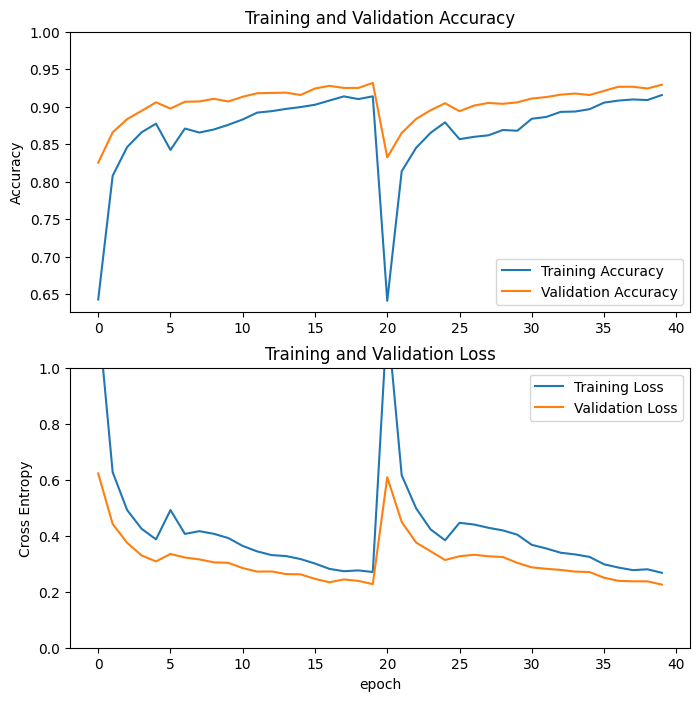

In [32]:
loss_MFT, accuracy_MFT = model_MFT.evaluate(test_dataset)
acc_MFT, val_acc_MFT, loss_MFT, val_loss_MFT = loadHistory('MFTmobnetGarbage')
distplayHistory(acc_MFT, val_acc_MFT, loss_MFT, val_loss_MFT)

MOBILENET SLOW TRANSFER

In [33]:
preprocess_input_MST= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MST= IMG_SIZE + (3,)
mobilenet_model_MST= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MST,
                                               include_top=False)
mobilenet_model_MST.trainable = False
image_batch_MST, label_batch_MST= next(iter(train_dataset))
feature_batch_MST= mobilenet_model_MST(image_batch_MST)

global_average_layer_MST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MST= global_average_layer_MST(feature_batch_MST)

fc1_layer_MST= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MST= fc1_layer_MST(feature_batch_average_MST)

prediction_layer_MST= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_MST= prediction_layer_MST(fc1_batch_MST)

inputs_MST= tf.keras.Input(shape=(160, 160, 3))
x_MST= preprocess_input_MST(inputs_MST)
x_MST= mobilenet_model_MST(x_MST)
x_MST= global_average_layer_MST(x_MST)
x_MST= tf.keras.layers.Dropout(0.2)(x_MST)
x_MST= fc1_layer_MST(x_MST)
x_MST= tf.keras.layers.Dropout(0.2)(x_MST)
outputs_MST= prediction_layer_MST(x_MST)
model_MST= tf.keras.Model(inputs_MST, outputs_MST)
model_MST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MST= "training_models/Garbage_MST.ckpt"
checkpoint_dir_MST= os.path.dirname(checkpoint_path_MST)
cp_callback_MST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [34]:
total_epochs_MST = 10
history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST])
initial_epochs_MST=total_epochs_MST
dumpHistory('MSTmobnetGarbage', history_MST)

Epoch 1/10
195/195 [==============================] - 64s 314ms/step - loss: 1.1635 - accuracy: 0.6521 - val_loss: 0.6007 - val_accuracy: 0.8335
Epoch 2/10
195/195 [==============================] - 60s 307ms/step - loss: 0.6158 - accuracy: 0.8119 - val_loss: 0.4450 - val_accuracy: 0.8657
Epoch 3/10
195/195 [==============================] - 58s 297ms/step - loss: 0.4906 - accuracy: 0.8460 - val_loss: 0.3676 - val_accuracy: 0.8869
Epoch 4/10
195/195 [==============================] - 59s 302ms/step - loss: 0.4251 - accuracy: 0.8641 - val_loss: 0.3289 - val_accuracy: 0.9003
Epoch 5/10
195/195 [==============================] - 59s 301ms/step - loss: 0.3766 - accuracy: 0.8761 - val_loss: 0.3078 - val_accuracy: 0.9042
Epoch 6/10
195/195 [==============================] - 59s 301ms/step - loss: 0.3504 - accuracy: 0.8883 - val_loss: 0.2946 - val_accuracy: 0.9077
Epoch 7/10
195/195 [==============================] - 59s 302ms/step - loss: 0.3229 - accuracy: 0.8963 - val_loss: 0.2801 - val_ac

In [35]:
mobilenet_model_MST.trainable = True
fine_tune_at_MST = 72
for layer_MST in mobilenet_model_MST.layers[:fine_tune_at_MST]:
  layer_MST.trainable = False
model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MST = 2
total_epochs_MST =  initial_epochs_MST + fine_tune_epochs_MST

history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=initial_epochs_MST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST])
dumpHistory('MSTmobnetGarbage', history_MST)
initial_epochs_MST += fine_tune_epochs_MST
for i in range (4):
  mobilenet_model_MST.trainable = True
  fine_tune_at_MST -= 18
  for layer_MST in mobilenet_model_MST.layers[:fine_tune_at_MST]:
    layer_MST.trainable = False
  model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MST = 2
  total_epochs_MST =  initial_epochs_MST + fine_tune_epochs_MST


  history_MST = model_MST.fit(train_dataset,
                          epochs=total_epochs_MST,
                          initial_epoch=initial_epochs_MST,
                          validation_data=validation_dataset, callbacks=[cp_callback_MST])
  dumpHistory('MSTmobnetGarbage', history_MST)
  initial_epochs_MST+=fine_tune_epochs_MST


Epoch 11/12
195/195 [==============================] - 70s 343ms/step - loss: 0.3554 - accuracy: 0.8817 - val_loss: 0.2611 - val_accuracy: 0.9144
Epoch 12/12
195/195 [==============================] - 66s 337ms/step - loss: 0.3273 - accuracy: 0.8900 - val_loss: 0.2656 - val_accuracy: 0.9144
DUMPED

Epoch 13/14
195/195 [==============================] - 81s 399ms/step - loss: 0.3336 - accuracy: 0.8928 - val_loss: 0.2695 - val_accuracy: 0.9128
Epoch 14/14
195/195 [==============================] - 77s 393ms/step - loss: 0.3154 - accuracy: 0.8987 - val_loss: 0.2614 - val_accuracy: 0.9148
DUMPED

Epoch 15/16
195/195 [==============================] - 90s 443ms/step - loss: 0.3204 - accuracy: 0.8979 - val_loss: 0.2669 - val_accuracy: 0.9144
Epoch 16/16
195/195 [==============================] - 86s 440ms/step - loss: 0.3174 - accuracy: 0.8980 - val_loss: 0.2607 - val_accuracy: 0.9168
DUMPED

Epoch 17/18
195/195 [==============================] - 109s 543ms/step - loss: 0.3089 - accuracy: 0.

In [36]:
model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MST = 5
total_epochs_MST =  initial_epochs_MST + add_epochs_MST

history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=initial_epochs_MST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST, clr])
initial_epochs_MST+=add_epochs_MST
dumpHistory('MSTmobnetGarbage', history_MST)

Epoch 21/25
195/195 [==============================] - 136s 685ms/step - loss: 0.2593 - accuracy: 0.9151 - val_loss: 0.2257 - val_accuracy: 0.9278
Epoch 22/25
195/195 [==============================] - 142s 727ms/step - loss: 0.2382 - accuracy: 0.9238 - val_loss: 0.2152 - val_accuracy: 0.9313
Epoch 23/25
195/195 [==============================] - 142s 728ms/step - loss: 0.2418 - accuracy: 0.9221 - val_loss: 0.2189 - val_accuracy: 0.9293
Epoch 24/25
195/195 [==============================] - 142s 729ms/step - loss: 0.2355 - accuracy: 0.9242 - val_loss: 0.2151 - val_accuracy: 0.9297
Epoch 25/25
195/195 [==============================] - 142s 728ms/step - loss: 0.2293 - accuracy: 0.9255 - val_loss: 0.2171 - val_accuracy: 0.9309
DUMPED



9/9 [==============================] - 3s 241ms/step - loss: 0.2354 - accuracy: 0.9306


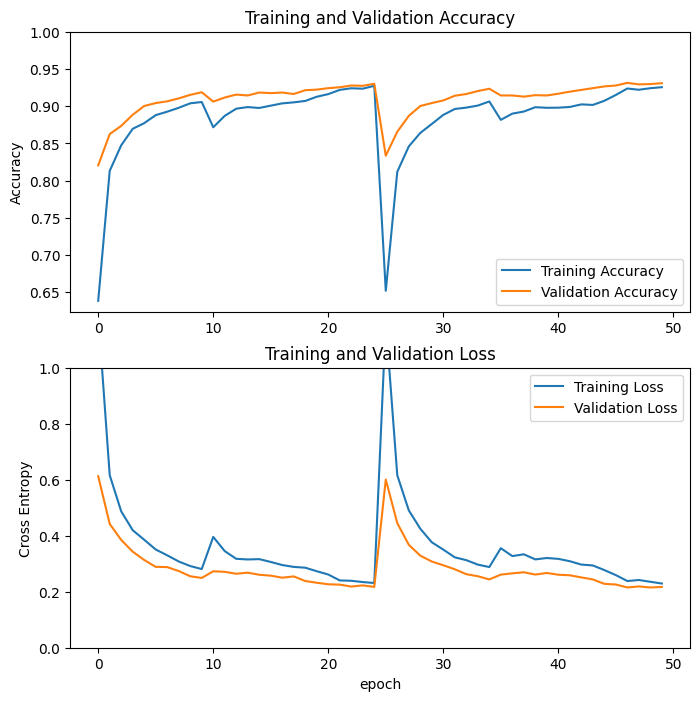

In [37]:
loss_MST, accuracy_MST = model_MST.evaluate(test_dataset)
acc_MST, val_acc_MST, loss_MST, val_loss_MST = loadHistory('MSTmobnetGarbage')
distplayHistory(acc_MST, val_acc_MST, loss_MST, val_loss_MST)

MOBILE NET PARTICAL TRANSFER

In [38]:
preprocess_input_MPT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MPT= IMG_SIZE + (3,)
mobilenet_model_MPT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MPT,
                                               include_top=False)
mobilenet_model_MPT.trainable = False
image_batch_MPT, label_batch_MPT= next(iter(train_dataset))
feature_batch_MPT= mobilenet_model_MPT(image_batch_MPT)

global_average_layer_MPT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MPT= global_average_layer_MPT(feature_batch_MPT)

fc1_layer_MPT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MPT= fc1_layer_MPT(feature_batch_average_MPT)

prediction_layer_MPT= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_MPT= prediction_layer_MPT(fc1_batch_MPT)

inputs_MPT= tf.keras.Input(shape=(160, 160, 3))
x_MPT= preprocess_input_MPT(inputs_MPT)
x_MPT= mobilenet_model_MPT(x_MPT)
x_MPT= global_average_layer_MPT(x_MPT)
x_MPT= tf.keras.layers.Dropout(0.2)(x_MPT)
x_MPT= fc1_layer_MPT(x_MPT)
x_MPT= tf.keras.layers.Dropout(0.2)(x_MPT)
outputs_MPT= prediction_layer_MPT(x_MPT)
model_MPT= tf.keras.Model(inputs_MPT, outputs_MPT)
model_MPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MPT= "training_models/Garbage_MPT.ckpt"
checkpoint_dir_MPT= os.path.dirname(checkpoint_path_MPT)
cp_callback_MPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MPT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [39]:
total_epochs_MPT = 20
history_MPT = model_MPT.fit(train_dataset,
                         epochs=total_epochs_MPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MPT])
initial_epochs_MPT=total_epochs_MPT
dumpHistory('MPTmobnetGarbage', history_MPT)

Epoch 1/20
195/195 [==============================] - 60s 296ms/step - loss: 1.1825 - accuracy: 0.6404 - val_loss: 0.6350 - val_accuracy: 0.8186
Epoch 2/20
195/195 [==============================] - 57s 293ms/step - loss: 0.6206 - accuracy: 0.8115 - val_loss: 0.4526 - val_accuracy: 0.8665
Epoch 3/20
195/195 [==============================] - 58s 296ms/step - loss: 0.4944 - accuracy: 0.8461 - val_loss: 0.3828 - val_accuracy: 0.8834
Epoch 4/20
195/195 [==============================] - 58s 294ms/step - loss: 0.4267 - accuracy: 0.8647 - val_loss: 0.3474 - val_accuracy: 0.8920
Epoch 5/20
195/195 [==============================] - 58s 294ms/step - loss: 0.3859 - accuracy: 0.8773 - val_loss: 0.3272 - val_accuracy: 0.8948
Epoch 6/20
195/195 [==============================] - 58s 294ms/step - loss: 0.3513 - accuracy: 0.8851 - val_loss: 0.3041 - val_accuracy: 0.9081
Epoch 7/20
195/195 [==============================] - 58s 294ms/step - loss: 0.3312 - accuracy: 0.8926 - val_loss: 0.2843 - val_ac

In [40]:
checkpoint_path_MPT= "training_models/Garbage_MFPT.ckpt"
checkpoint_dir_MPT= os.path.dirname(checkpoint_path_MPT)
cp_callback_MPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MPT,
                                                 save_weights_only=True,
                                                 verbose=0)
total_epochs_MPT = 40
history_MPT = model_MPT.fit(train_dataset,
                         epochs=total_epochs_MPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MPT, clr])
initial_epochs_MPT=total_epochs_MPT
dumpHistory('MPTmobnetGarbage', history_MPT)

Epoch 1/40
195/195 [==============================] - 58s 296ms/step - loss: 0.2011 - accuracy: 0.9330 - val_loss: 0.2186 - val_accuracy: 0.9282
Epoch 2/40
195/195 [==============================] - 58s 296ms/step - loss: 0.1962 - accuracy: 0.9355 - val_loss: 0.2146 - val_accuracy: 0.9301
Epoch 3/40
195/195 [==============================] - 58s 296ms/step - loss: 0.2013 - accuracy: 0.9320 - val_loss: 0.2205 - val_accuracy: 0.9289
Epoch 4/40
195/195 [==============================] - 58s 296ms/step - loss: 0.1991 - accuracy: 0.9335 - val_loss: 0.2177 - val_accuracy: 0.9297
Epoch 5/40
195/195 [==============================] - 58s 297ms/step - loss: 0.2023 - accuracy: 0.9328 - val_loss: 0.2209 - val_accuracy: 0.9285
Epoch 6/40
195/195 [==============================] - 58s 298ms/step - loss: 0.1998 - accuracy: 0.9317 - val_loss: 0.2155 - val_accuracy: 0.9289
Epoch 7/40
195/195 [==============================] - 58s 298ms/step - loss: 0.1956 - accuracy: 0.9344 - val_loss: 0.2069 - val_ac

9/9 [==============================] - 2s 240ms/step - loss: 0.2373 - accuracy: 0.9236


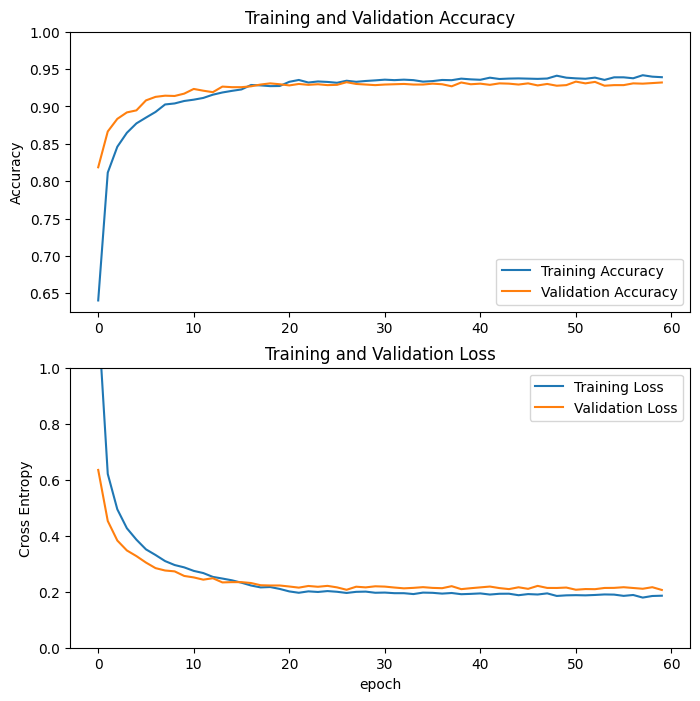

In [41]:
loss_MPT, accuracy_MPT = model_MPT.evaluate(test_dataset)
acc_MPT, val_acc_MPT, loss_MPT, val_loss_MPT = loadHistory('MPTmobnetGarbage')
distplayHistory(acc_MPT, val_acc_MPT, loss_MPT, val_loss_MPT)

MOBILE NET VERY SLOW TRANSFER

In [42]:
preprocess_input_MVST= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MVST= IMG_SIZE + (3,)
mobilenet_model_MVST= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MVST,
                                               include_top=False)
mobilenet_model_MVST.trainable = False
image_batch_MVST, label_batch_MVST= next(iter(train_dataset))
feature_batch_MVST= mobilenet_model_MVST(image_batch_MVST)

global_average_layer_MVST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MVST= global_average_layer_MVST(feature_batch_MVST)

fc1_layer_MVST= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MVST= fc1_layer_MVST(feature_batch_average_MVST)

prediction_layer_MVST= tf.keras.layers.Dense(12, activation=tf.keras.activations.softmax)
prediction_batch_MVST= prediction_layer_MVST(fc1_batch_MVST)

inputs_MVST= tf.keras.Input(shape=(160, 160, 3))
x_MVST= preprocess_input_MVST(inputs_MVST)
x_MVST= mobilenet_model_MVST(x_MVST)
x_MVST= global_average_layer_MVST(x_MVST)
x_MVST= tf.keras.layers.Dropout(0.2)(x_MVST)
x_MVST= fc1_layer_MVST(x_MVST)
x_MVST= tf.keras.layers.Dropout(0.2)(x_MVST)
outputs_MVST= prediction_layer_MVST(x_MVST)
model_MVST= tf.keras.Model(inputs_MVST, outputs_MVST)
model_MVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MVST= "training_models/Garbage_MVST.ckpt"
checkpoint_dir_MVST= os.path.dirname(checkpoint_path_MVST)
cp_callback_MVST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [43]:
model_MVST.load_weights("training_models/Garbage_MPT.ckpt")
mobilenet_model_MVST.trainable = True
initial_epochs_MVST=20
fine_tune_at_MVST = 72
for layer_MVST in mobilenet_model_MVST.layers[:fine_tune_at_MVST]:
  layer_MVST.trainable = False
model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MVST = 1
total_epochs_MVST =  initial_epochs_MVST + fine_tune_epochs_MVST

history_MVST = model_MVST.fit(train_dataset,
                         epochs=total_epochs_MVST,
                         initial_epoch=initial_epochs_MVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MVST])
dumpHistory('MVSTmobnetGarbage', history_MVST)
initial_epochs_MVST += fine_tune_epochs_MVST
for i in range (9):
  mobilenet_model_MVST.trainable = True
  fine_tune_at_MVST -= 8
  for layer_MVST in mobilenet_model_MVST.layers[:fine_tune_at_MVST]:
    layer_MVST.trainable = False
  model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MVST = 1
  total_epochs_MVST =  initial_epochs_MVST + fine_tune_epochs_MVST


  history_MVST = model_MVST.fit(train_dataset,
                          epochs=total_epochs_MVST,
                          initial_epoch=initial_epochs_MVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_MVST])
  dumpHistory('MVSTmobnetGarbage', history_MVST)
  initial_epochs_MVST+=fine_tune_epochs_MVST


Epoch 21/21
195/195 [==============================] - 67s 332ms/step - loss: 0.2850 - accuracy: 0.9053 - val_loss: 0.2301 - val_accuracy: 0.9282
DUMPED

Epoch 22/22
195/195 [==============================] - 73s 360ms/step - loss: 0.2765 - accuracy: 0.9066 - val_loss: 0.2280 - val_accuracy: 0.9270
DUMPED

Epoch 23/23
195/195 [==============================] - 78s 386ms/step - loss: 0.2644 - accuracy: 0.9120 - val_loss: 0.2404 - val_accuracy: 0.9278
DUMPED

Epoch 24/24
195/195 [==============================] - 81s 402ms/step - loss: 0.2640 - accuracy: 0.9123 - val_loss: 0.2313 - val_accuracy: 0.9258
DUMPED

Epoch 25/25
195/195 [==============================] - 87s 431ms/step - loss: 0.2570 - accuracy: 0.9131 - val_loss: 0.2400 - val_accuracy: 0.9223
DUMPED

Epoch 26/26
195/195 [==============================] - 91s 452ms/step - loss: 0.2500 - accuracy: 0.9181 - val_loss: 0.2320 - val_accuracy: 0.9258
DUMPED

Epoch 27/27
195/195 [==============================] - 100s 496ms/step - los

In [44]:
model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MVST = 5
total_epochs_MVST =  initial_epochs_MVST + add_epochs_MVST

history_MVST = model_MVST.fit(train_dataset,
                         epochs=total_epochs_MVST,
                         initial_epoch=initial_epochs_MVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MVST, clr])
initial_epochs_MVST+=add_epochs_MVST
dumpHistory('MVSTmobnetGarbage', history_MVST)

Epoch 31/35
195/195 [==============================] - 147s 737ms/step - loss: 0.2213 - accuracy: 0.9270 - val_loss: 0.2202 - val_accuracy: 0.9282
Epoch 32/35
195/195 [==============================] - 143s 732ms/step - loss: 0.2135 - accuracy: 0.9279 - val_loss: 0.2065 - val_accuracy: 0.9321
Epoch 33/35
195/195 [==============================] - 143s 732ms/step - loss: 0.2110 - accuracy: 0.9302 - val_loss: 0.1989 - val_accuracy: 0.9352
Epoch 34/35
195/195 [==============================] - 142s 726ms/step - loss: 0.1857 - accuracy: 0.9393 - val_loss: 0.1924 - val_accuracy: 0.9372
Epoch 35/35
195/195 [==============================] - 132s 677ms/step - loss: 0.1815 - accuracy: 0.9412 - val_loss: 0.1905 - val_accuracy: 0.9360
DUMPED



9/9 [==============================] - 3s 243ms/step - loss: 0.2045 - accuracy: 0.9340


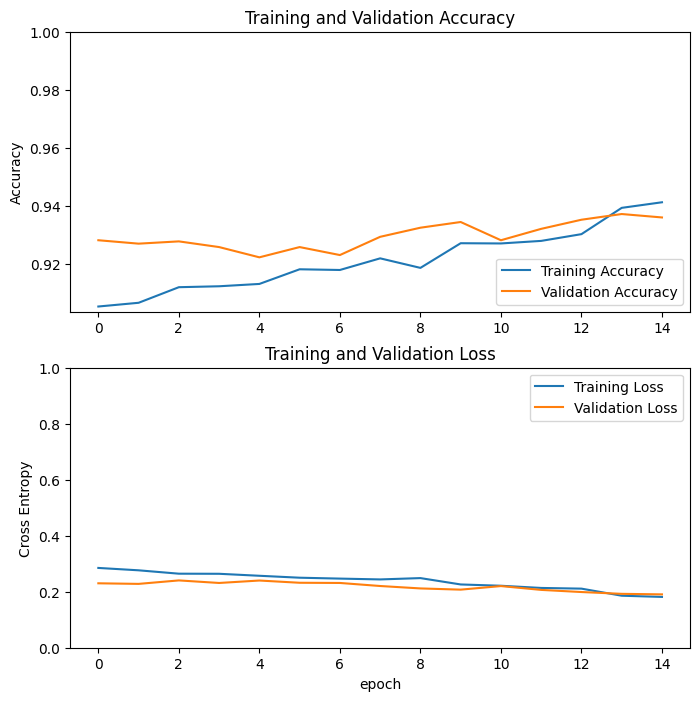

In [45]:
loss_MVST, accuracy_MVST = model_MVST.evaluate(test_dataset)
acc_MVST, val_acc_MVST, loss_MVST, val_loss_MVST = loadHistory('MVSTmobnetGarbage')
distplayHistory(acc_MVST, val_acc_MVST, loss_MVST, val_loss_MVST)